In [1]:
import numpy as np
%matplotlib inline
import Corrfunc
import glob
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import nbodykit

import utils
import plotter
import bao_utils

%load_ext autoreload
%autoreload 2

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import pylab
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.dpi'] = 80
textsize = 'x-large'
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6, 4),
         'axes.labelsize': textsize,
         'axes.titlesize': textsize,
         'xtick.labelsize': textsize,
         'ytick.labelsize': textsize}
pylab.rcParams.update(params)

In [2]:
def load_data(cat_tag, cf_tag, Nrealizations=100, return_amps=False):
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    xis = []
    amps = []
    n_converged = 0

    for Nr in range(Nrealizations):

        if 'baoiter' in cf_tag:
            fn_pattern = f"cf{cf_tag}_converged_*{cat_tag}_rlz{Nr}.npy"
            matches = glob.glob(f'{result_dir}/{fn_pattern}')
            for cf_fn in matches:
                r_avg, xi, amp, _, _ = np.load(cf_fn, allow_pickle=True)
                n_converged +=1
                break #should only be 1 match; but probs better way to do this
            if len(matches)==0:
                continue
        else:
            cf_fn = '{}/cf{}{}_rlz{}.npy'.format(result_dir, cf_tag, cat_tag, Nr)
            r_avg, xi, amp, proj, extra = np.load(cf_fn, allow_pickle=True)
        rs.append(r_avg)
        xis.append(xi)
        amps.append(amp)
        
    if 'baoiter' in cf_tag:
        print(f'Number converged: {n_converged}/{Nrealizations}')
        
    if return_amps:
        return rs, xis, amps
    else:
        return rs, xis

In [3]:
def plot_cf_err(rs, cf_arrs, r_true, cf_true, labels, colors, err=False, xlim=None, errlim=None, cont=True, bases=None):
    
    if np.array(rs).ndim == 1:
        rs = [rs]
    if np.array(cf_arrs).ndim == 2:
        cf_arrs = np.array([cf_arrs])
    
    cfs_mean = []
    error_regions = []
    for cfs in cf_arrs:
        mean = np.mean(cfs, axis=0)
        cfs_mean.append(mean)
        std = np.std(cfs, axis=0)
        error_regions.append([mean-std, mean+std])
    
    ax = plotter.plot_cf_cont(rs, cfs_mean, r_true, cf_true, labels, colors, error_regions=error_regions, 
                         err=err, xlim=xlim, errlim=errlim, cont=cont, bases=bases)
    return ax

In [4]:
def plot_continuous(cat_tag, cf_tags, Nrealizations=100, colors=None, labels=None, err=True, errlim=None, 
                    cont=True, show_bases=True, xlim=None, peak_fit=False, bws=[], r_widths=[], r_max_true=None, b1=2.0):
    
    if colors is None:
        colors = ['lime','blue', 'cyan', 'magenta', 'purple']
    if labels is None:
        labels = [f"{tag.split('_')[1]}, bin width {tag.split('bw')[-1]}" for tag in cf_tags]
    if xlim is None:
        xlim = [40.0, 148.0]
    
    cat_dir = '../catalogs'
    result_dir = '../results/results_lognormal{}'.format(cat_tag)

    rs = []
    r_arrs = []
    cf_arrs = []
    bases = None
    if show_bases:
        bases = []

    for i in range(len(cf_tags)):
        cf_tag = cf_tags[i]
        xis = []
        rarr = []
        n_converged = 0

        rarr, xis = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations, return_amps=False)
        #rarr.append(r_avg)
        #xis.append(xi)
        r_avg = rarr[0]
        rs.append(r_avg)
        r_arrs.append(rarr)
        cf_arrs.append(xis)     

        if show_bases:
            if 'tophat' in cf_tag:
                rmin = min(r_avg)
                rmax = max(r_avg)
                binwidth = float(cf_tag.split('bw')[-1])
                r_edges = np.arange(rmin, rmax+binwidth, binwidth)
                base = np.zeros((len(r_avg), len(r_edges))) #r_edges - 1 (bc edges not bins), +1 (bc ravg)
                base[:,0] = r_avg
                for rr in range(len(r_edges)-1):
                    base[:,rr+1] = [1.0 if r_edges[rr]<=r_avg[jj]<r_edges[rr+1] else 0.0 for jj in range(len(r_avg))]
            else:
                if 'baoiter' in cf_tag:
                    rmin, rmax = 36.0, 200.0
                    redshift = 0.57
                    bias = 2.0
                    projfn = f'../tables/bases{cf_tag}_r{rmin}-{rmax}_z{redshift}_bias{bias}.dat'
                else:
                    projfn = f'../tables/bases{cf_tag}.dat'
                base = np.loadtxt(projfn)
                bmax = max(np.array([base[bb,1:] for bb in range(base.shape[0]) if xlim[0]<base[bb,0]<xlim[1]]).flatten())
                base[:,1:] /= bmax   
            bases.append(base)        
        
    true_fn = '{}/inputs/cat{}_Rh_xi.txt'.format(cat_dir, cat_tag)
    r_true, xi_true = np.loadtxt(true_fn, unpack=True)
    xi_true *= b1**2

    ax = plot_cf_err(rs, cf_arrs, r_true, xi_true, labels, colors, err=err, xlim=xlim, 
                errlim=errlim, cont=cont, bases=bases)
    
    if peak_fit:
        r_peak_guess = 100.0
        r_peak_arr, *_ = find_peaks_center(r_arrs, cf_arrs, r_peak_guess, bws=bws, r_widths=r_widths)
        for i in range(len(cf_tags)):
            r_med = np.nanmedian(r_peak_arr[i])
            r_p16 = np.nanpercentile(r_peak_arr[i], 16)
            r_p84 = np.nanpercentile(r_peak_arr[i], 84)
            ax[0].errorbar(r_med, 0.008+i*0.001, xerr=[[r_med-r_p16], [r_p84-r_med]], fmt='o', 
                           color=colors[i], markersize=4)
        if r_max_true is not None:
            ax[0].errorbar(r_max_true, 0.008-0.001, fmt='o', color='k', markersize=4)
        return ax, r_peak_arr
    else:
        return ax

In [5]:
ctopmany = '#33BBEE'
ctopmid = '#3547F1'
ctopfew = '#0077BB'
cspline = '#EE3377'
cbao = '#228833'
ctheory = '#808080'

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


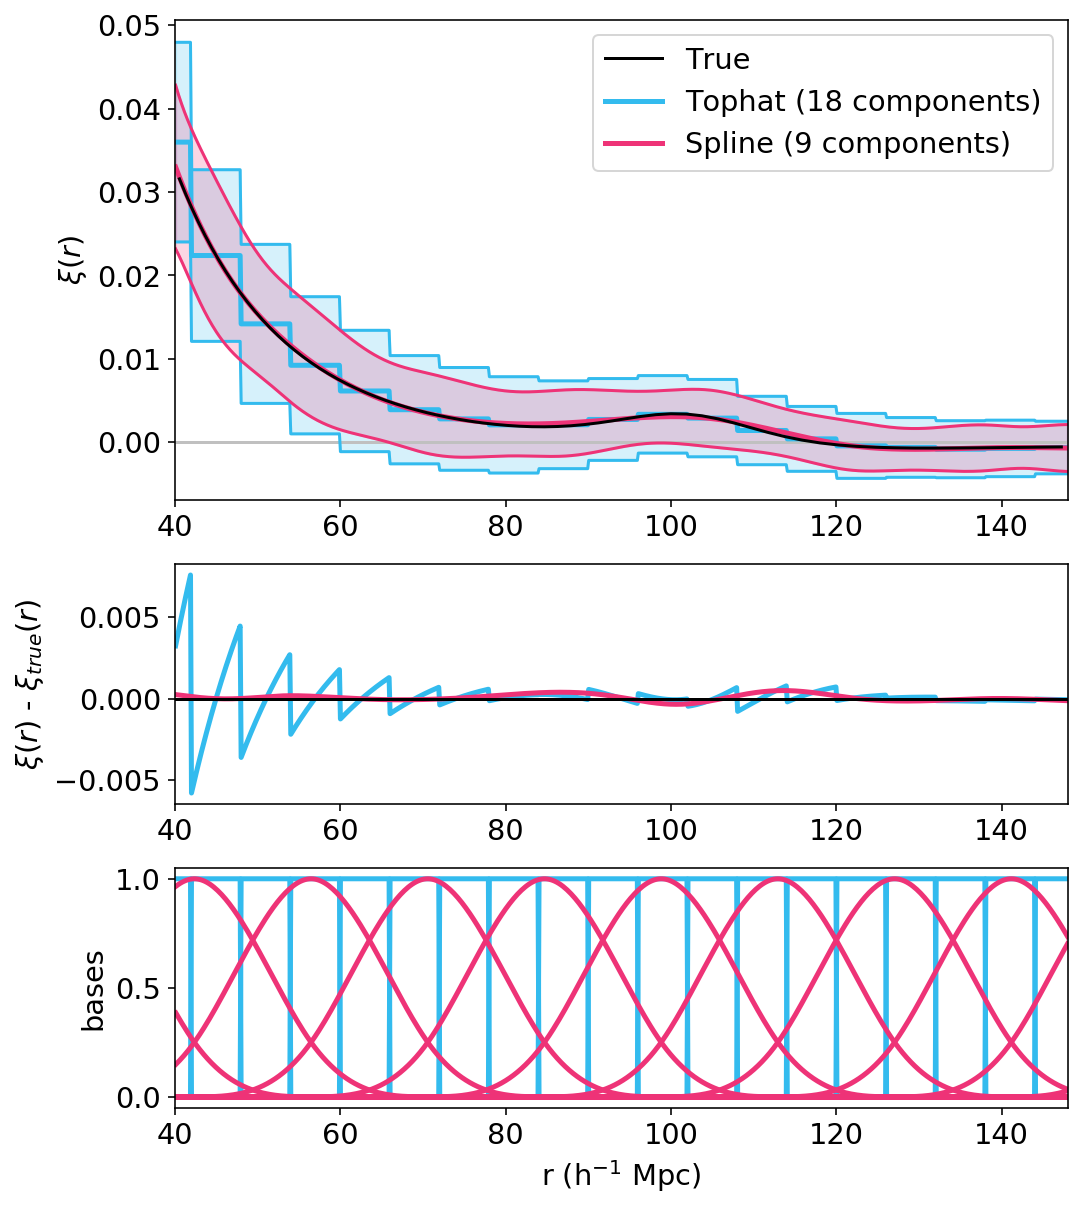

In [14]:
cat_tag = '_L750_n2e-5_z057'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


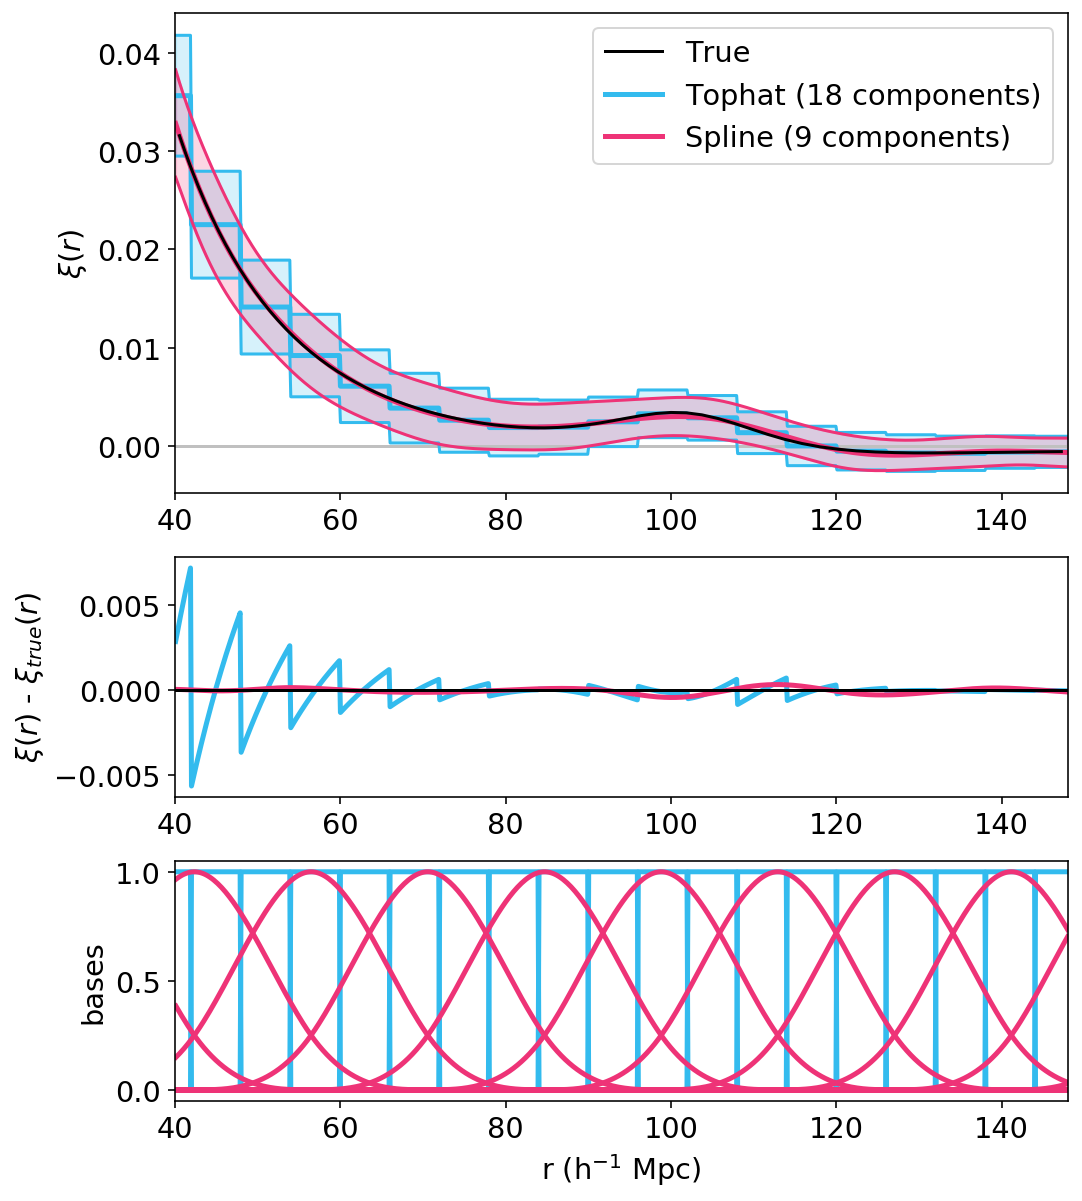

In [15]:
cat_tag = '_L750_n5e-5_z057'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


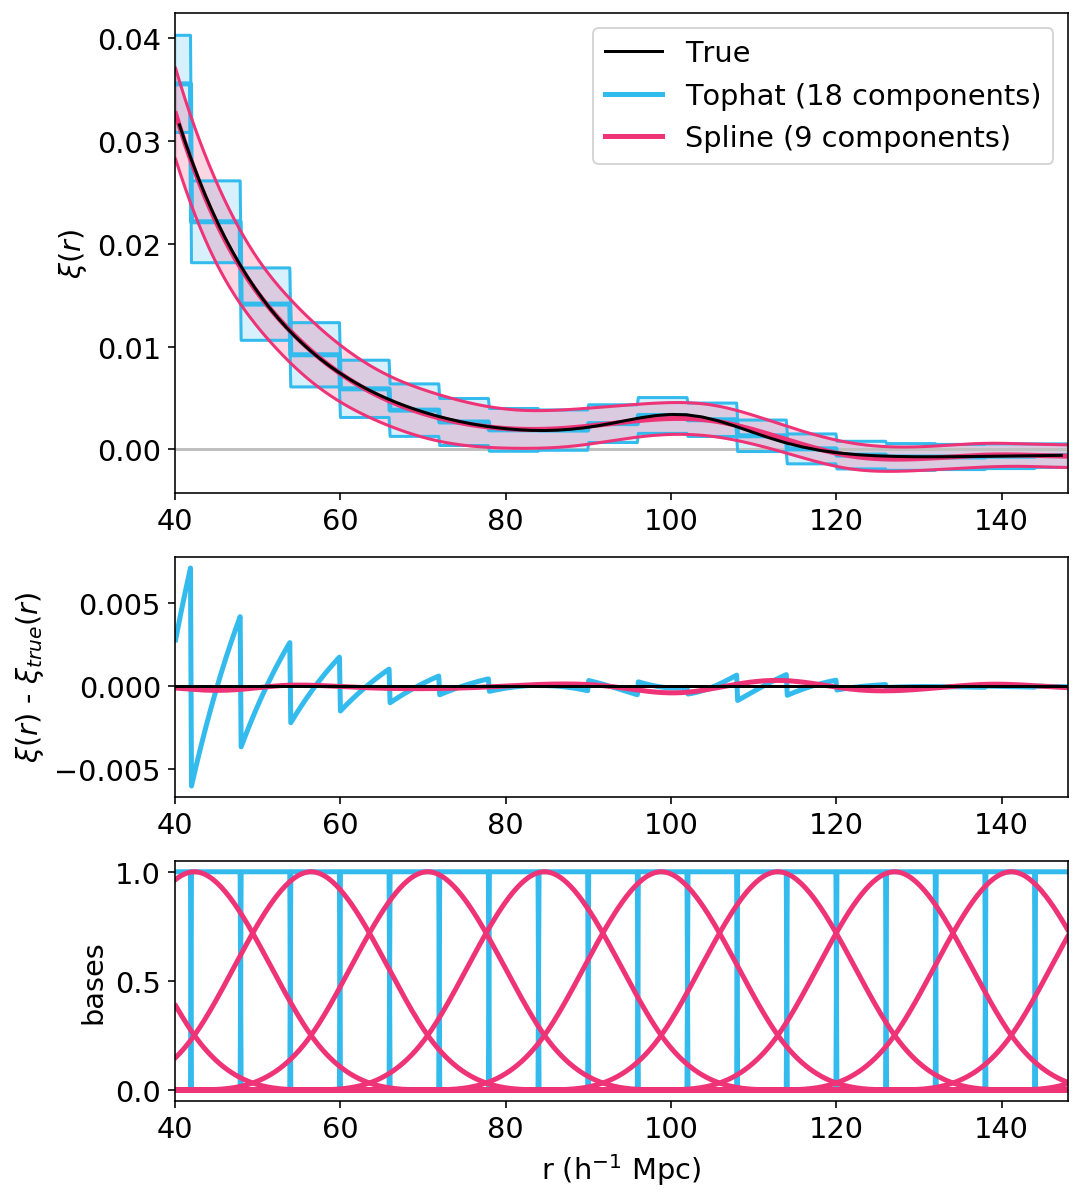

In [18]:
cat_tag = '_L750_n1e-4_z057'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

(2, 1000)
rmse: True
plotting
0.0010186 100000.0


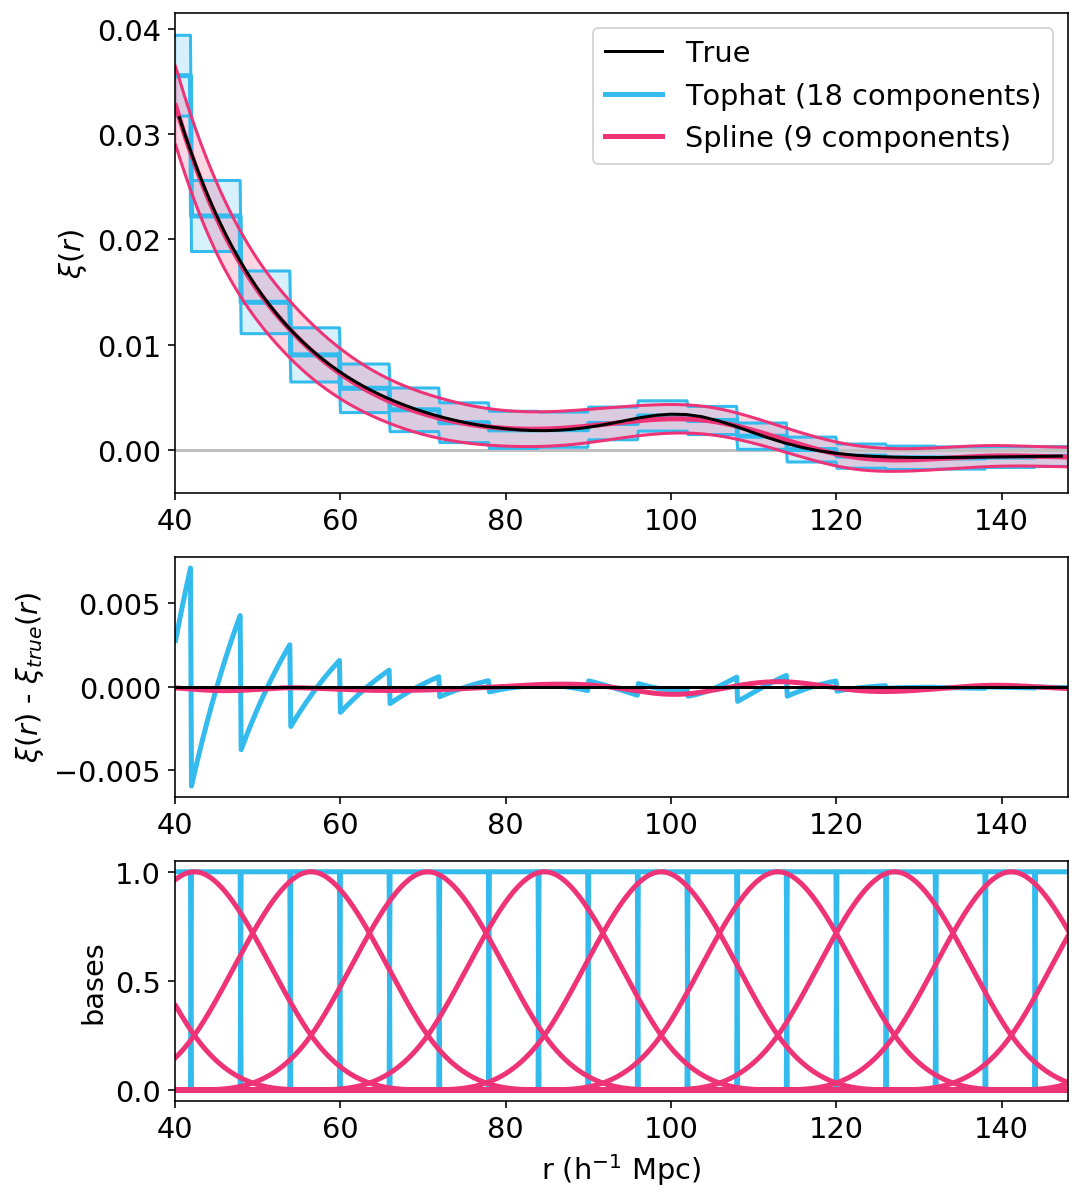

In [19]:
cat_tag = '_L750_n2e-4_z057'
cf_tags = ['_tophat_bw6', '_spline3_bw12']
colors = [ctopmany, cspline]
labels = ['Tophat (18 components)', 'Spline (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

(3, 1000)
rmse: True
plotting
0.0010186 100000.0


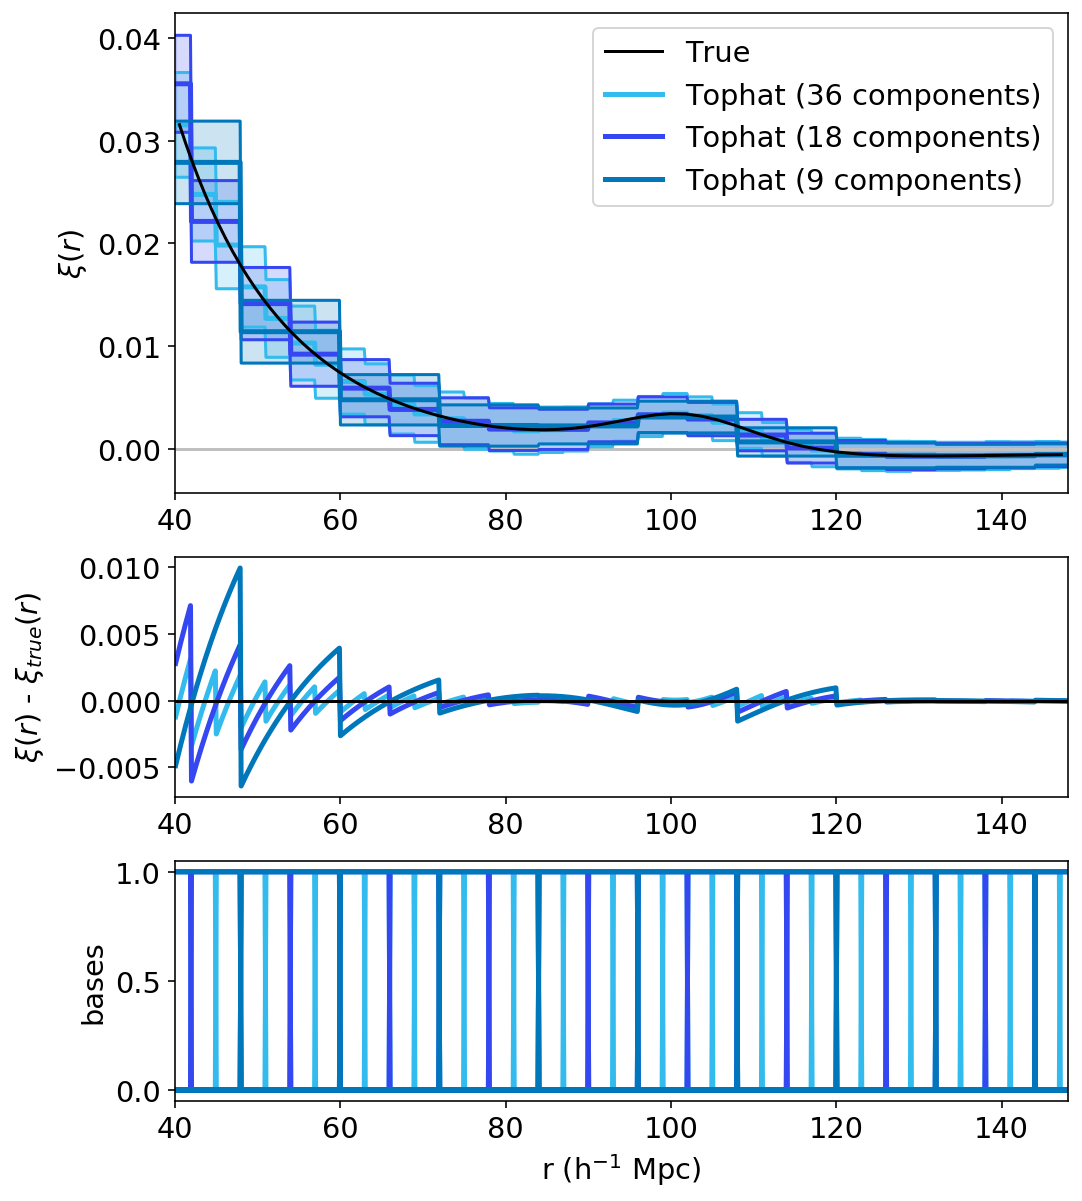

In [15]:
cat_tag = '_L750_n1e-4_z057'
cf_tags = ['_tophat_bw3', '_tophat_bw6', '_tophat_bw12']
colors = [ctopmany, ctopmid, ctopfew]
labels = ['Tophat (36 components)', 'Tophat (18 components)', 'Tophat (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

In [ ]:
cat_tag = '_L750_n1e-4_z057'
cf_tags = ['_tophat_bw3', '_tophat_bw6', '_tophat_bw12']
colors = [ctopmany, ctopmid, ctopfew]
labels = ['Tophat (36 components)', 'Tophat (18 components)', 'Tophat (9 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

## BAO 

What is alpha supposed to be?

In [6]:
import nbodykit

#Params for assumed cosmology for BAO basis
Omega0_cdm = 0.31
Omega0_b = 0.04814
h0 = 0.676
ns = 0.96
cosmo_b17 = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, n_s=ns)

#Params used to generate lognormal (Planck)
oc0h2 = 0.11880 # \Omega_c h^2
mnu = 0.00   # \Sigma m_{\nu} total neutrino mass
ns = 0.9667
lnAs = 3.064
ob0h2 = 0.02230 #\Omega_baryon h^2
h0 = 0.6774 # H0/100
w = -1.0
run = 0.0 # running index pf pk
m_ncdm = [] #pass empty list for no massive neutrinos
Omega0_b = ob0h2 / h0**2
Omega0_cdm = oc0h2 / h0**2
cosmo_planck = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                            m_ncdm=m_ncdm, n_s=ns)

z = 0.57
alpha_true = bao_utils.compute_alpha(z, cosmo_planck, cosmo_b17) #1st is truth, 2nd is fiducial

Cosmo: r_s: 158.26595003520382 D_A: 1386.683612636117 Mpc H: 92.95294554563436 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 1362.8322033846473 Mpc H: 96.36955022372915 km / (Mpc s)
alpha: 0.9809725024612357


In [10]:
cosmo_b17 = bao_utils.get_cosmo('b17')
cosmo_planck = bao_utils.get_cosmo('planck')

z = 0.57
alpha_true = bao_utils.compute_alpha(z, cosmo_planck, cosmo_b17) #1st is truth, 2nd is fiducial

Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 1362.8322033846473 Mpc H: 96.36955022372915 km / (Mpc s)
alpha: 0.9802843982009106


In [32]:
0.9809725024612357/0.9802843982009106

1.0007019434988336

### 2e-5

Number converged: 982/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


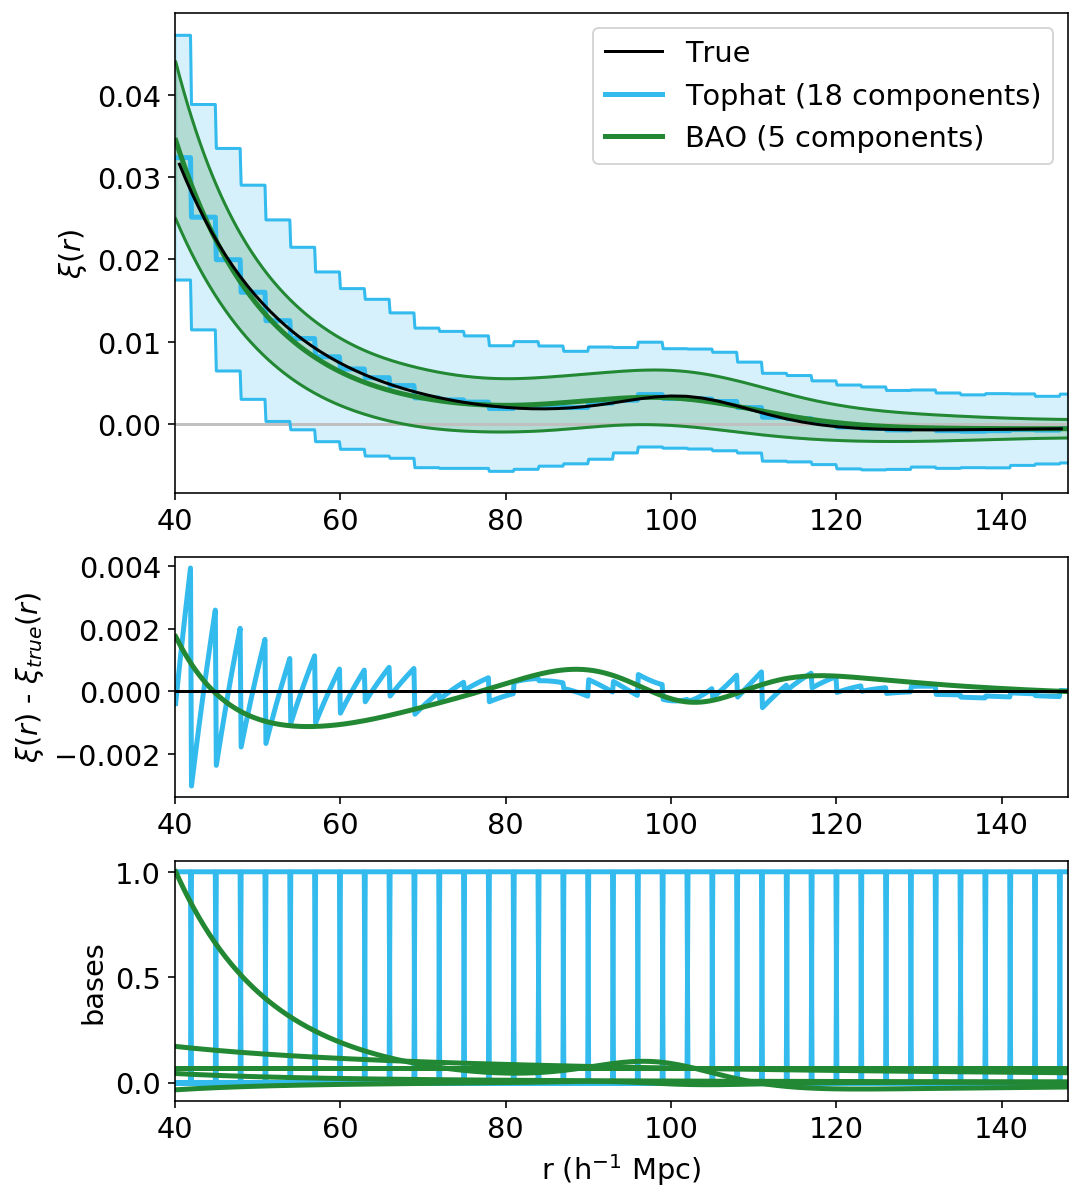

In [41]:
cat_tag = '_L750_n2e-5_z057'
cf_tags = ['_tophat_bw3', '_baoiter_cosmob17']
colors = [ctopmany, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

In [42]:
cat_tag = '_L750_n2e-5_z057'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.calc_alpha(cat_tag, cf_tag, realizations=range(1000))

_baoiter_cosmob17
Found 982 converged BAO cfs (18 not converged)
alpha_mean: 0.9791720125612058
alpha_median: 0.9674782638206626
alpha_std: 0.11094379771878064


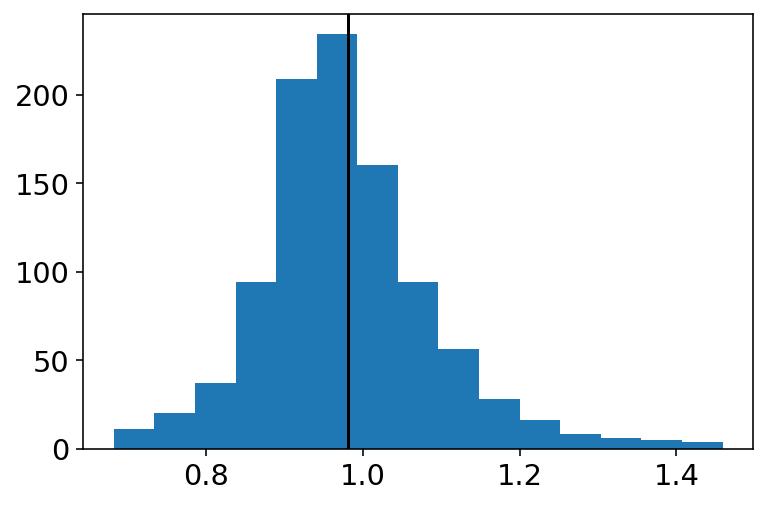

In [43]:
plt.hist(alphas, bins=15)
plt.axvline(alpha_true, color='black')

### 5e-5

Number converged: 874/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


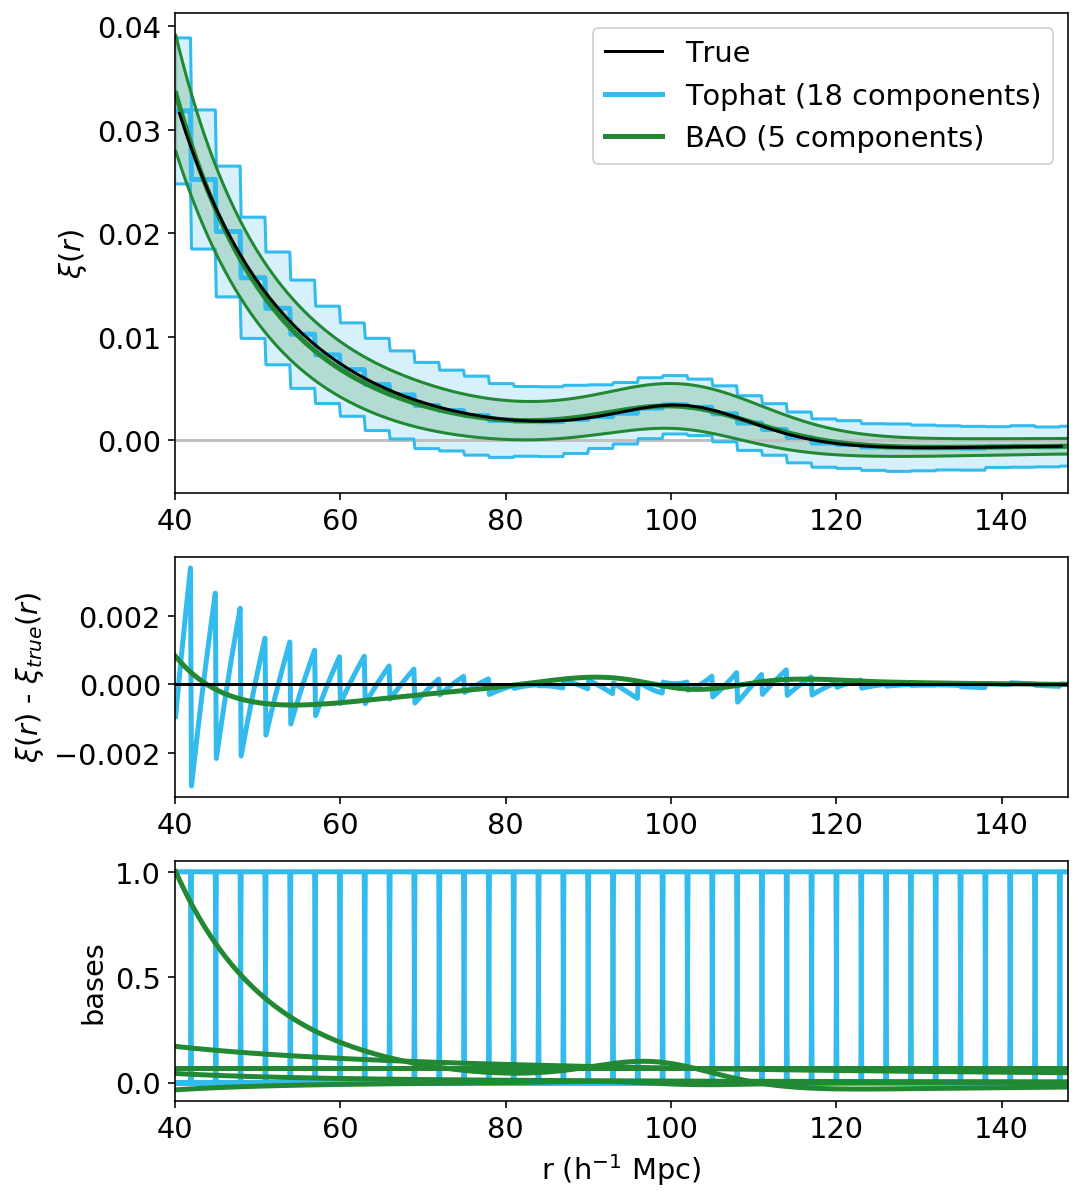

In [7]:
cat_tag = '_L750_n5e-5_z057'
cf_tags = ['_tophat_bw3', '_baoiter_cosmob17']
colors = [ctopmany, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

In [16]:
cat_tag = '_L750_n5e-5_z057'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))

Found 953 converged BAO cfs (47 not converged)
alpha_mean: 0.9634772009180557
alpha_median: 0.9594206101521053
alpha_std: 0.06378735838901488


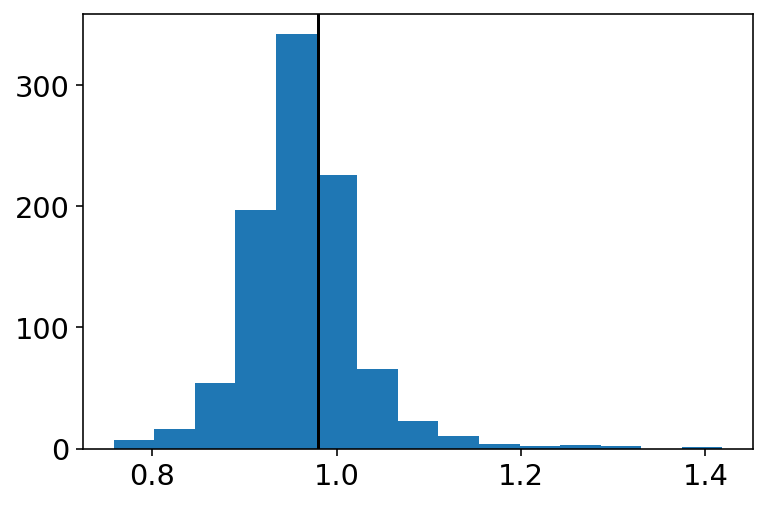

In [17]:
plt.hist(alphas, bins=15)
plt.axvline(alpha_true, color='black')
#plt.yscale('log')

### 1e-4

Number converged: 980/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


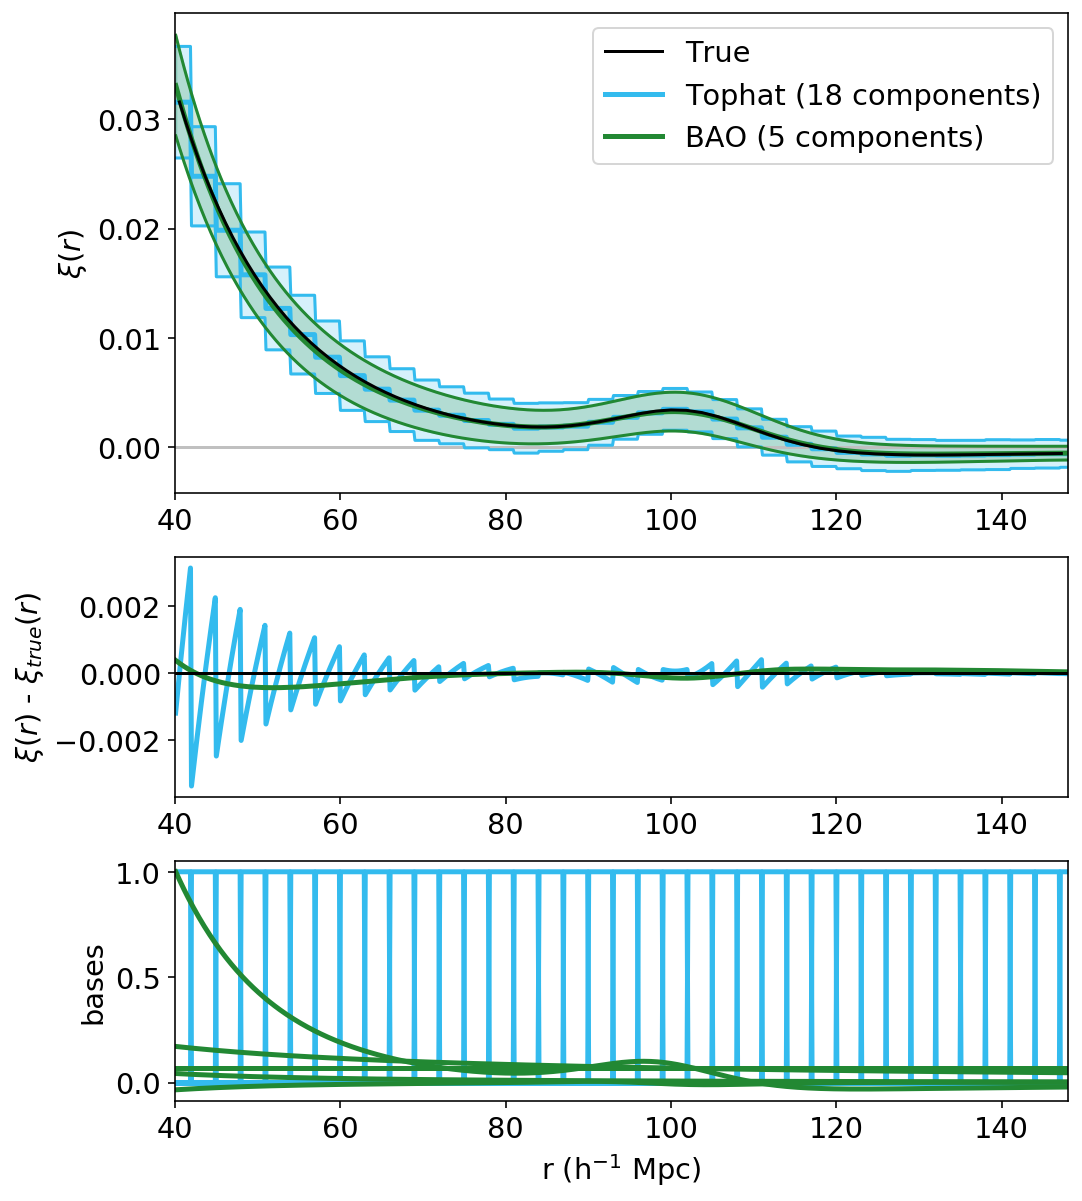

In [47]:
cat_tag = '_L750_n1e-4_z057'
cf_tags = ['_tophat_bw3', '_baoiter_cosmob17']
colors = [ctopmany, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

In [33]:
cat_tag = '_L750_n1e-4_z057'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.calc_alpha(cat_tag, cf_tag, realizations=range(1000))

_baoiter_cosmob17
Found 980 converged BAO cfs (20 not converged)
alpha_mean: 0.9601486423290005
alpha_median: 0.957482579730528
alpha_std: 0.041282198052647004


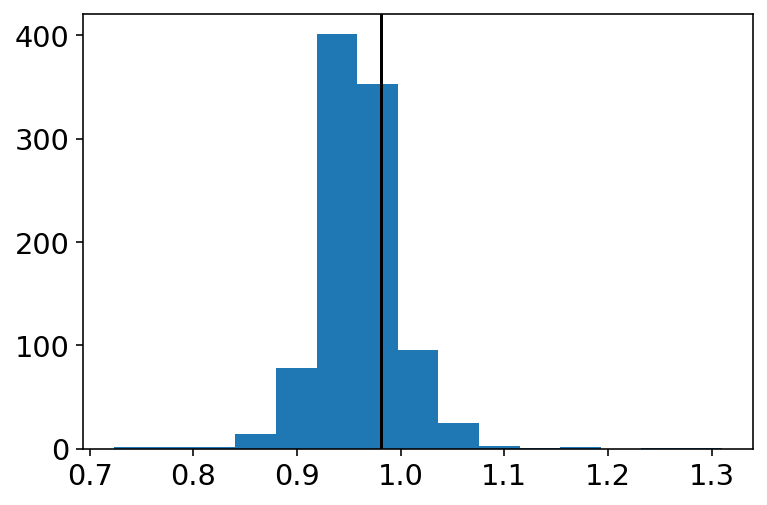

In [34]:
plt.hist(alphas, bins=15)
plt.axvline(alpha_true, color='black')

### 2e-4

Number converged: 961/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


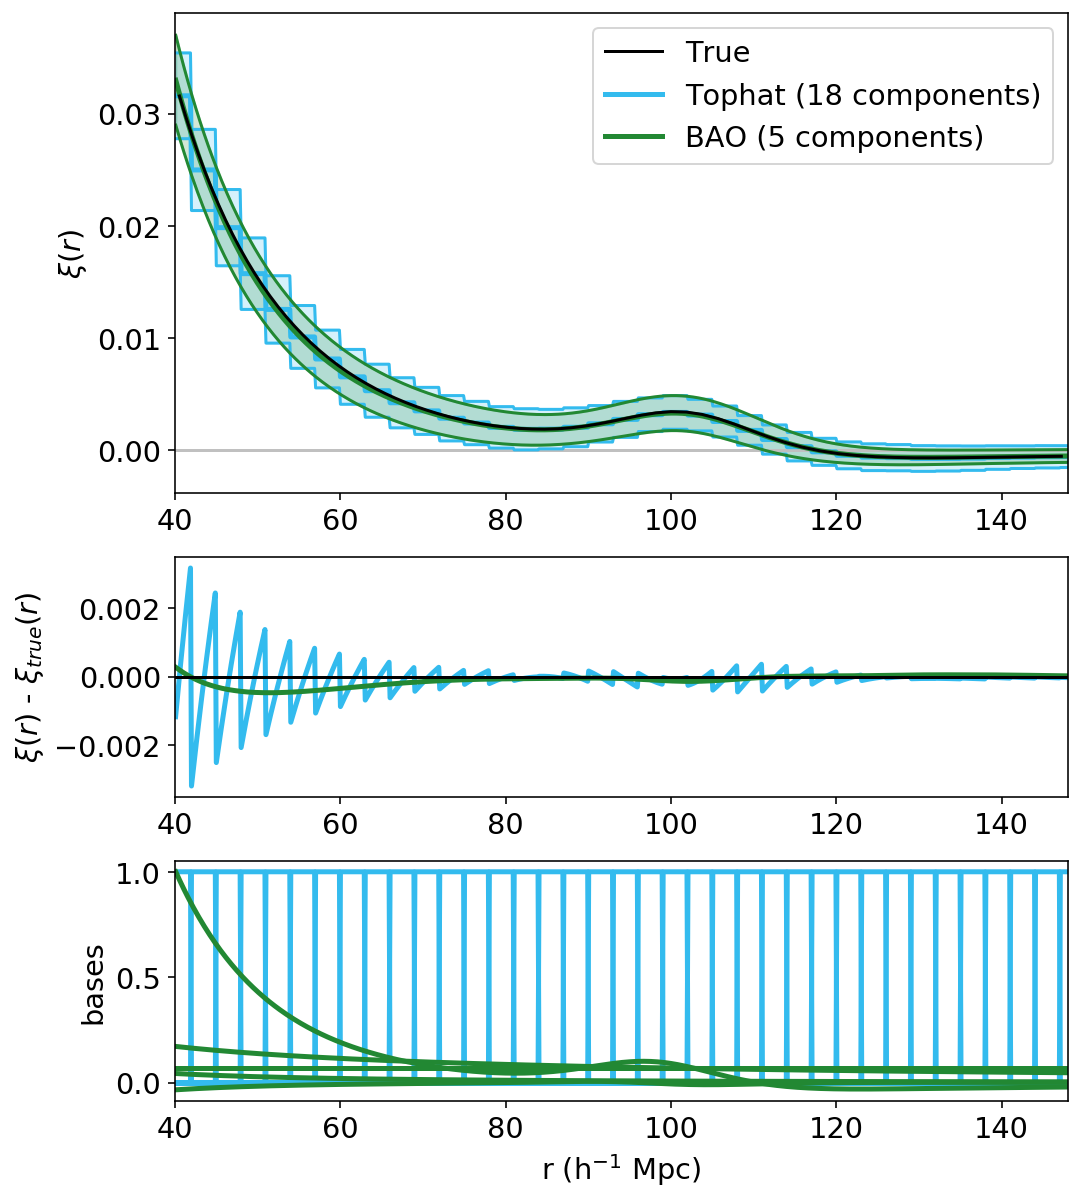

In [11]:
cat_tag = '_L750_n2e-4_z057'
cf_tags = ['_tophat_bw3', '_baoiter_cosmob17']
colors = [ctopmany, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000)

In [11]:
cat_tag = '_L750_n2e-4_z057'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))

Found 985 converged BAO cfs (15 not converged)
alpha_mean: 0.9594194364702171
alpha_median: 0.9583487033792292
alpha_std: 0.027550849687011134


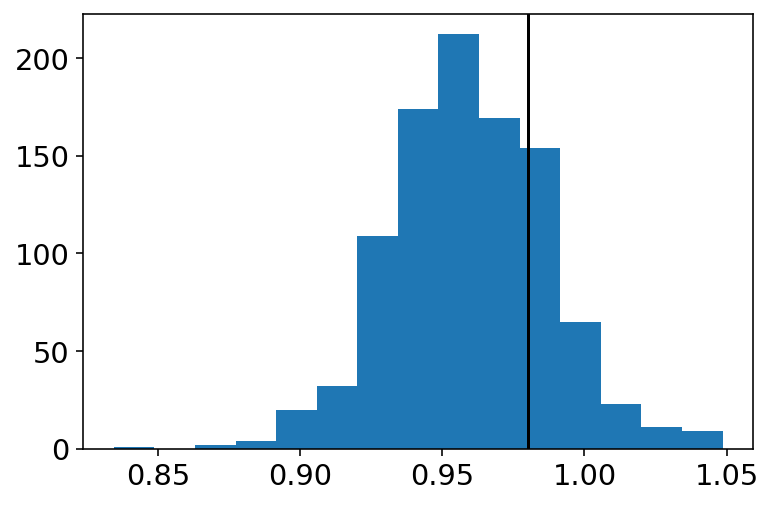

In [12]:
plt.hist(alphas, bins=15)
plt.axvline(alpha_true, color='black')

In [17]:
cat_tag = '_L750_n2e-4_z057'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.calc_alpha(cat_tag, cf_tag, realizations=range(300))

_baoiter_cosmob17
Found 287 converged BAO cfs (13 not converged)
alpha_mean: 0.9624436730573649
alpha_median: 0.9591944025601306
alpha_std: 0.027143501390770573


## Standard fitting method

In [125]:
cat_tag = '_L750_n5e-5_z057'
cf_tag = '_theory_bw6'
Nrealizations = 100
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

0.9729779133971275 0.9587854364052197 0.12401042750998414


(0.8, 1.2)

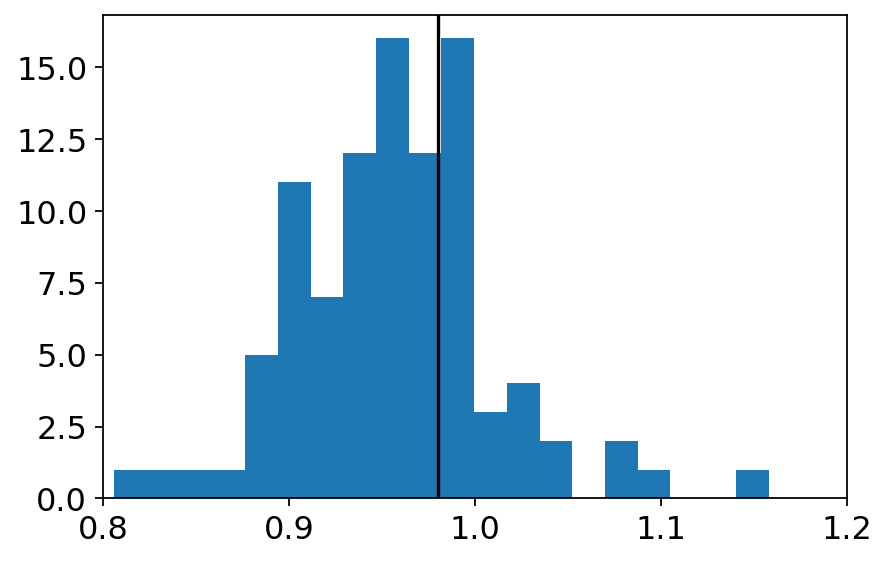

In [126]:
print(np.nanmean(alphas_standard), np.nanmedian(alphas_standard), np.nanstd(alphas_standard))
plt.hist(alphas_standard, bins=55)
plt.axvline(alpha_true, color='black')
plt.xlim(0.8, 1.2)

(0.8, 1.2)

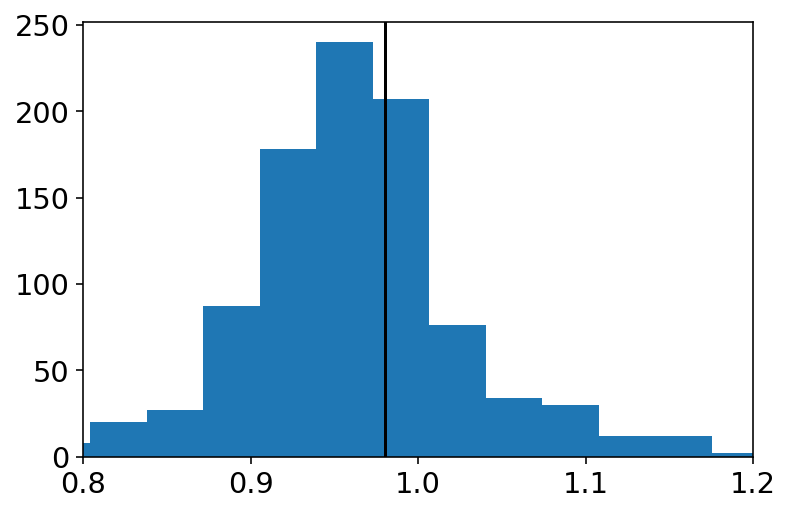

In [67]:
plt.hist(alphas, bins=55)
plt.axvline(alpha_true, color='black')
plt.xlim(0.8, 1.2)

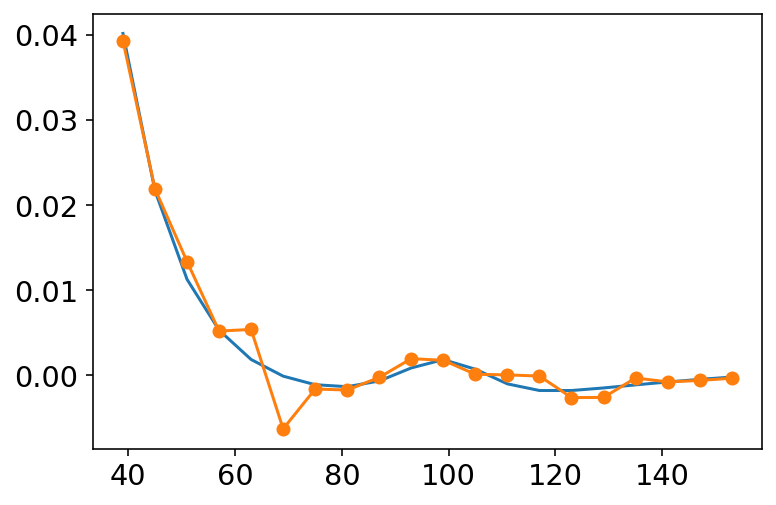

In [55]:
plt.plot(r_points, bao_fit(r_points, *popt))
plt.plot(r_points, xi_points, marker='o', ls='None', color='grey')

In [69]:
cat_tag = '_L750_n2e-4_z057'
cf_tag = '_baoiter_cosmob17'
Nrealizations = 1000
rarr, xis, amp = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations, return_amps=True)
print(np.array(rarr).shape)
print(np.array(xis).shape)    

Number converged: 961/1000
(961, 1000)
(961, 1000)


In [ ]:
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

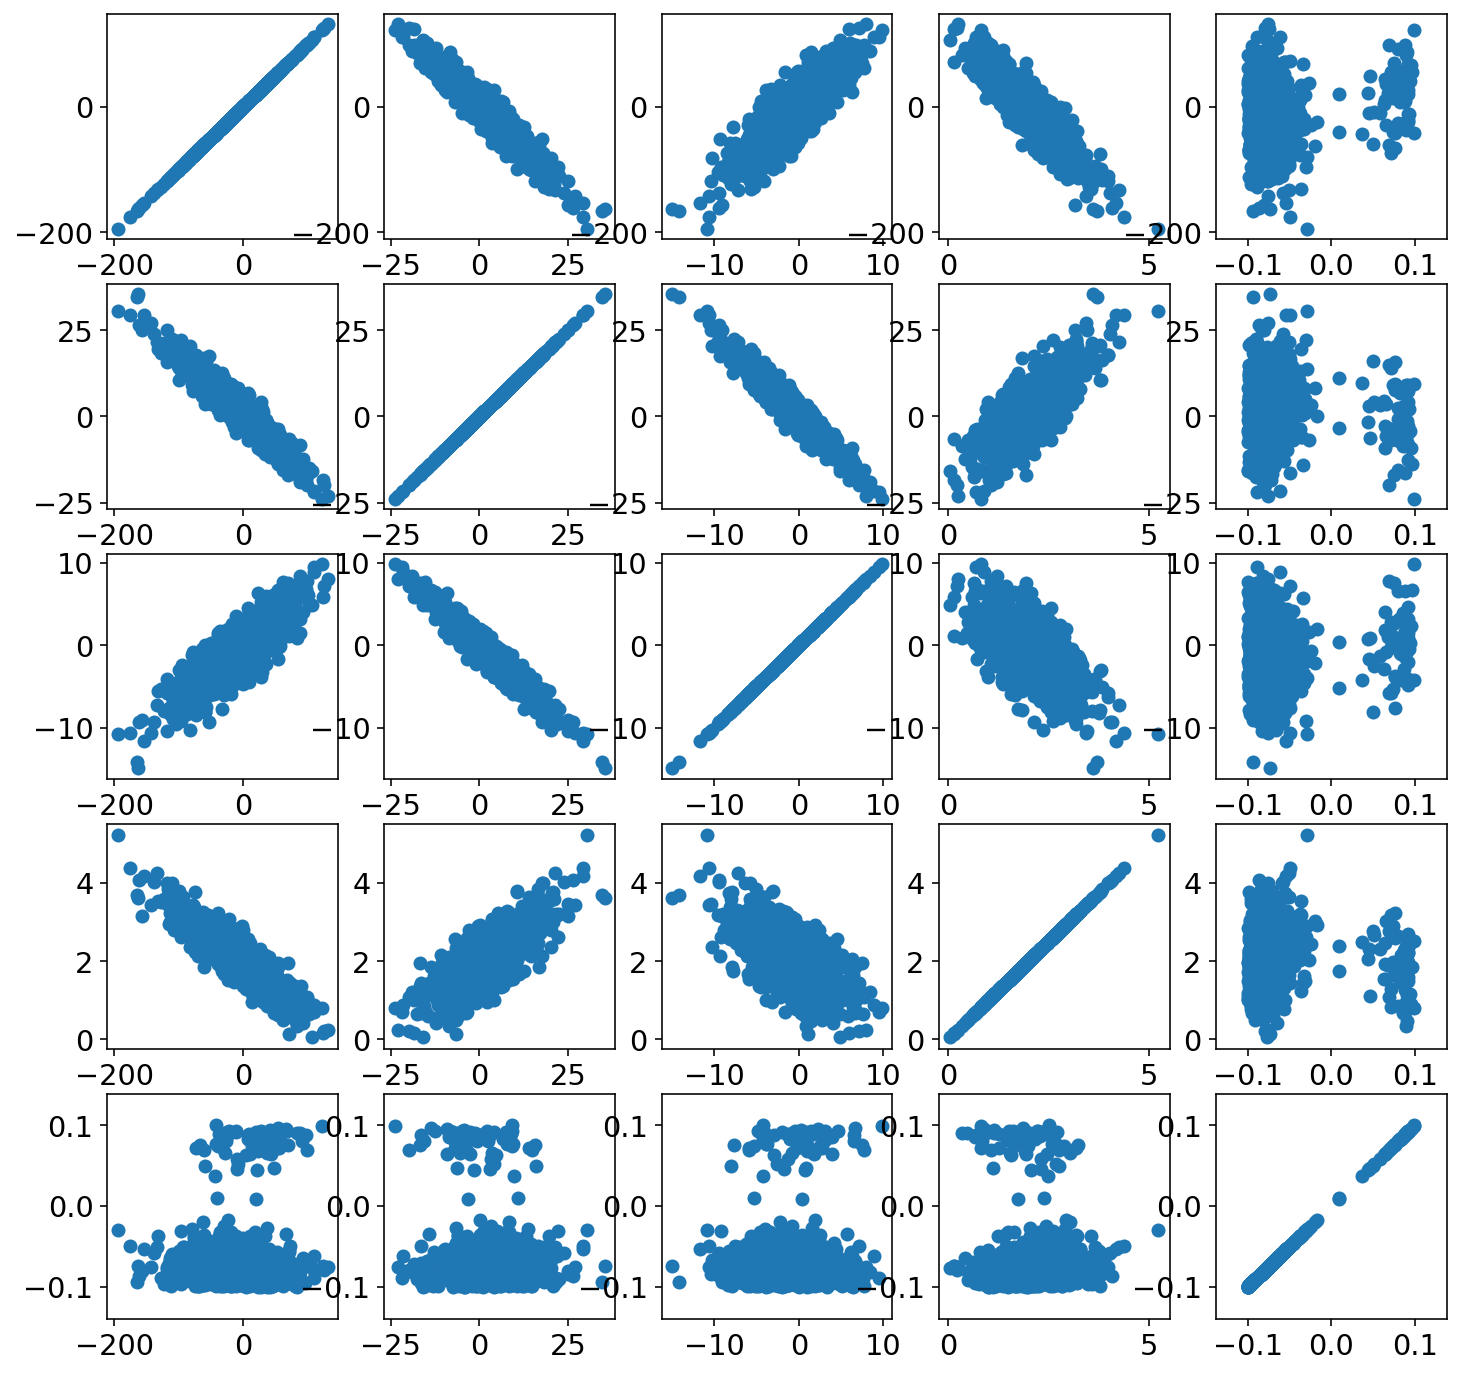

In [81]:
amp = np.array(amp)
fig, axarr = plt.subplots(5, 5, figsize=(12,12))
for i in range(amp.shape[1]):
    for j in range(amp.shape[1]):
        ax = axarr[i][j]
        ax.scatter(amp[:,j], amp[:,i])
        #ax.set_xlabel(i)
        #ax.set_ylabel(j)

## Planck Test

In [18]:
cosmo_planck = bao_utils.get_cosmo('planck')

z = 0.57
alpha_true_planck = bao_utils.compute_alpha(z, cosmo_planck, cosmo_planck) #1st is truth, 2nd is fiducial

Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
alpha: 1.0


In [31]:
bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_b17)

Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 1362.8322033846473 Mpc H: 96.36955022372915 km / (Mpc s)
alpha: 0.9802843982009106


<Quantity 0.9802844>

In [30]:
bao_utils.compute_alpha(0.01, cosmo_planck, cosmo_b17)

Cosmo: r_s: 158.26434744831286 D_A: 43.71640223542587 Mpc H: 68.05640359909451 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 43.79031723715237 Mpc H: 67.96735951976453 km / (Mpc s)
alpha: 0.9566073011746071


<Quantity 0.9566073>

In [33]:
bao_utils.compute_alpha(0.0001, cosmo_planck, cosmo_b17)

Cosmo: r_s: 158.26434744831286 D_A: 0.44250890795004943 Mpc H: 67.74314015738699 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 0.4434236621958584 Mpc H: 67.60364724649857 km / (Mpc s)
alpha: 0.9561280197065469


<Quantity 0.95612802>

In [13]:
cat_tag = '_L750_n5e-5_z057'
cf_tag = '_baoiter_cosmoplanck'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))

Found 890 converged BAO cfs (110 not converged)
alpha_mean: 1.0028138492015284
alpha_median: 1.000125646564511
alpha_std: 0.05548988848672577


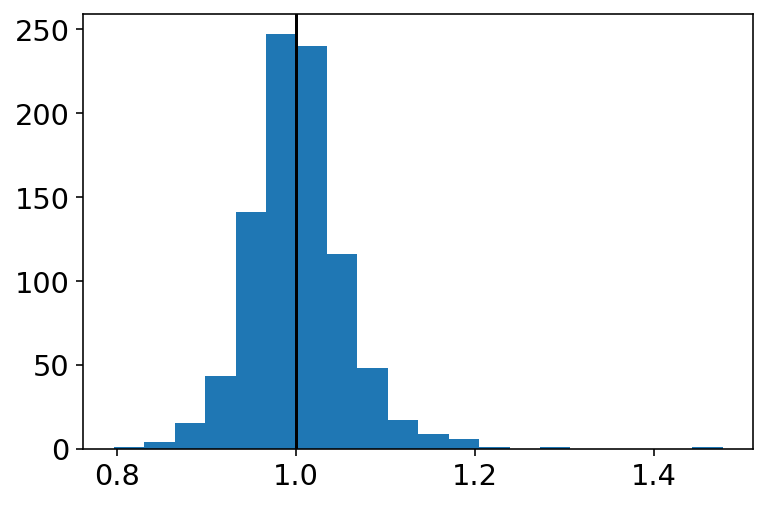

In [15]:
plt.hist(alphas, bins=20)
plt.axvline(1.0, color='black')

In [34]:
cat_tag = '_L750_n5e-5_z057'
cf_tag = '_theory_bw6'
Nrealizations = 1000
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)

In [35]:
cosmo_base = cosmo_planck
alphas_standard_planck = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

Optimal parameters for realization 44 not found! continuing
Optimal parameters for realization 880 not found! continuing


1.008513534296353 0.9993807041483225 0.10660645199490817


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/users/ksf293/miniconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(0.8, 1.2)

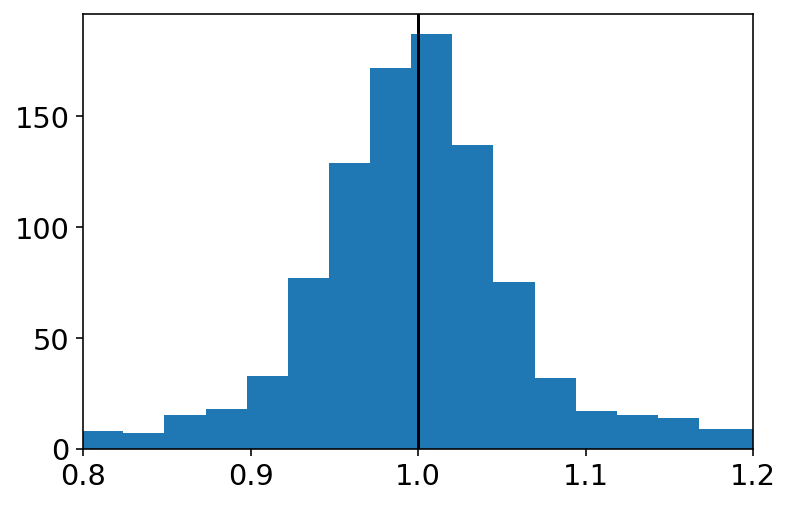

In [37]:
print(np.nanmean(alphas_standard_planck), np.nanmedian(alphas_standard_planck), np.nanstd(alphas_standard_planck))
plt.hist(alphas_standard_planck, bins=55)
plt.axvline(alpha_true_planck, color='black')
plt.xlim(0.8, 1.2)

In [36]:
alpha_true

<Quantity 0.9802844>

In [38]:
cosmo_planck

In [46]:
help(cosmo_planck)

Help on Cosmology in module nbodykit.cosmology.cosmology object:

class Cosmology(builtins.object)
 |  Cosmology(h=0.67556, T0_cmb=2.7255, Omega0_b=0.0482754208891869, Omega0_cdm=0.26377065934278865, N_ur=None, m_ncdm=[0.06], P_k_max=10.0, P_z_max=100.0, gauge='synchronous', n_s=0.9667, nonlinear=False, verbose=False, **kwargs)
 |  
 |  A cosmology calculator based on the CLASS binding in :mod:`classylss`.
 |  
 |  It is a collection of all method provided by the CLASS interfaces.
 |  The object is immutable. To obtain an instance with a new set of parameters
 |  use :func:`clone` or :func:`match`.
 |  
 |  The individual interfaces can be accessed too, such that
 |  `c.Spectra.get_transfer` and `c.get_transfer` are identical.
 |  
 |  .. important::
 |  
 |      A default set of units is assumed. Those units are:
 |  
 |      * temperature: :math:`\mathrm{K}`
 |      * distance: :math:`h^{-1} \mathrm{Mpc}`
 |      * wavenumber: :math:`h \mathrm{Mpc}^{-1}`
 |      * power: :math:`h^{-3

In [47]:
print(cosmo_planck.sigma8)


0.8158116144901115

In [58]:
print(cosmo_planck.Omega0_lambda)
print(cosmo_planck.Omega0_m)
print(cosmo_planck.h)
print(cosmo_planck.n_s)

0.6910173428086966
0.30890374144332966
0.6774
0.9667


In [72]:
km_to_Mpc = 3.24078e-20

In [73]:
import cosmolopy.distance as cd
cosmo_b17_py = {'omega_M_0' : 0.31, 'omega_lambda_0' : (1-0.31-0.04814), 'h' : 0.676, 'omega_b_0':0.04814, 'n':0.96}
cosmo_b17_py = cd.set_omega_k_0(cosmo_b17_py)
z = 0.57
da_b17 = cd.angular_diameter_distance(z, **cosmo_b17_py)
H_b17 = cd.hubble_z(z, **cosmo_b17_py)/km_to_Mpc

In [74]:
import cosmolopy.distance as cd
cosmo_planck_py = {'omega_M_0' : cosmo_planck.Omega0_m, 'omega_lambda_0': cosmo_planck.Omega0_lambda, 
                   'h':cosmo_planck.h, 'omega_b_0':cosmo_planck.Omega0_b, 'n':cosmo_planck.n_s}
cosmo_planck_py = cd.set_omega_k_0(cosmo_planck_py)
z = 0.57
da_planck = cd.angular_diameter_distance(z, **cosmo_planck_py)
H_planck = cd.hubble_z(z, **cosmo_planck_py)/km_to_Mpc

1376.8155905181889 1385.9919910770298
94.64441480686651 93.04409442598197


In [60]:
bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_b17)

Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 1362.8322033846473 Mpc H: 96.36955022372915 km / (Mpc s)
alpha: 0.9802843982009106


<Quantity 0.9802844>

In [83]:
print(cosmo_planck_py['omega_M_0'], cosmo_planck_py['omega_b_0'], cosmo_planck_py['h'])
rs_planck = bao_utils.compute_radius_sound_horizon(cosmo_planck_py['omega_M_0'], cosmo_planck_py['omega_b_0'], cosmo_planck_py['h'])
print(cosmo_b17_py['omega_M_0'], cosmo_b17_py['omega_b_0'], cosmo_b17_py['h'])
rs_b17 = bao_utils.compute_radius_sound_horizon(cosmo_b17_py['omega_M_0'], cosmo_b17_py['omega_b_0'], cosmo_b17_py['h'])

0.30890374144332966 0.0486 0.6774
0.31 0.04814 0.676


In [82]:
print(da_b17, da_planck)
print(H_b17, H_planck)
print(rs_b17, rs_planck)

1376.8155905181889 1385.9919910770298
94.64441480686651 93.04409442598197
151.6335957884925 151.33872766346497


In [84]:
bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_b17)

0.2589 0.0486 0.6774
0.31 0.04814 0.676
Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 151.6335957884925 D_A: 1362.8322033846473 Mpc H: 96.36955022372915 km / (Mpc s)
alpha: 0.9802843982009106


<Quantity 0.9802844>

In [92]:
Omega0_m = 0.31
Omega0_b = 0.04814
Omega0_cdm = Omega0_m-Omega0_b
h0 = 0.676
ns = 0.96
print("Cosmo:", Omega0_cdm, Omega0_b, h0, ns)
cosmo_b17_correct = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, n_s=ns)
bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_b17_correct)

Cosmo: 0.26186 0.04814 0.676 0.96
0.2589 0.0486 0.6774
0.26186 0.04814 0.676
Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 158.27091326585514 D_A: 1387.4775717166528 Mpc H: 93.03626971186141 km / (Mpc s)
alpha: 0.9992470190198243


<Quantity 0.99924702>

In [47]:
#Params used to generate lognormal (Planck)
oc0h2 = 0.11880 # \Omega_c h^2
mnu = 0.00   # \Sigma m_{\nu} total neutrino mass
ns = 0.9667
lnAs = 3.064
ob0h2 = 0.02230 #\Omega_baryon h^2
h0 = 0.6774 # H0/100
w = -1.0
run = 0.0 # running index pf pk
m_ncdm = [] #pass empty list for no massive neutrinos
Omega0_b = ob0h2 / h0**2
Omega0_cdm = oc0h2 / h0**2
print("Cosmo:", Omega0_cdm, Omega0_b, h0, ns)
cosmo_planck_lognormal = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                            m_ncdm=m_ncdm, n_s=ns)

Cosmo: 0.2588964265232328 0.048597561544344206 0.6774 0.9667


In [91]:
bao_utils.compute_alpha(0.57, cosmo_planck_lognormal, cosmo_b17_correct)

0.2588964265232328 0.048597561544344206 0.6774
0.26186 0.04814 0.676
Cosmo: r_s: 158.26595003520382 D_A: 1386.683612636117 Mpc H: 92.95294554563436 km / (Mpc s)
Fiducial: r_s: 158.27091326585514 D_A: 1387.4775717166528 Mpc H: 93.03626971186141 km / (Mpc s)
alpha: 0.9999484339685538


<Quantity 0.99994843>

In [12]:
Omega0_m = 0.307115
Omega0_b = 0.048206
Omega0_cdm = Omega0_m-Omega0_b
h0 = 0.6777
ns = 0.9611
sigma_8 = 0.8288
print("Cosmo:", Omega0_cdm, Omega0_b, h0, ns)
cosmo_patchy = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, n_s=ns, sigma8=sigma_8)

Cosmo: 0.25890900000000006 0.048206 0.6777 0.9611


In [98]:
bao_utils.compute_alpha(0.57, cosmo_patchy, cosmo_b17_correct)

0.25890900000000006 0.048206 0.6777
0.26186 0.04814 0.676
Cosmo: r_s: 158.38224113487712 D_A: 1385.531684570546 Mpc H: 93.06560956380719 km / (Mpc s)
Fiducial: r_s: 158.27091326585514 D_A: 1387.4775717166528 Mpc H: 93.03626971186141 km / (Mpc s)
alpha: 0.9982576309299533


<Quantity 0.99825763>

In [99]:
bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_patchy)

0.2589 0.0486 0.6774
0.25890900000000006 0.048206 0.6777
Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 158.38224113487712 D_A: 1385.531684570546 Mpc H: 93.06560956380719 km / (Mpc s)
alpha: 1.0009911149779531


<Quantity 1.00099111>

In [100]:
Omega0_m = 0.2726
Omega0_b = 0.0456
Omega0_cdm = Omega0_m-Omega0_b
h0 = 0.704
ns = 0.963
sigma_8 = 0.809
print("Cosmo:", Omega0_cdm, Omega0_b, h0, ns)
cosmo_wmap9 = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, n_s=ns, sigma8=sigma_8)

Cosmo: 0.227 0.0456 0.704 0.963


In [101]:
bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_wmap9)

0.2589 0.0486 0.6774
0.227 0.0456 0.704
Cosmo: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 160.09020170265399 D_A: 1351.9816475047066 Mpc H: 94.09543175144744 km / (Mpc s)
alpha: 1.0322352957680647


<Quantity 1.0322353>

In [102]:
bao_utils.compute_alpha(0.57, cosmo_planck_lognormal, cosmo_wmap9)

0.2588964265232328 0.048597561544344206 0.6774
0.227 0.0456 0.704
Cosmo: r_s: 158.26595003520382 D_A: 1386.683612636117 Mpc H: 92.95294554563436 km / (Mpc s)
Fiducial: r_s: 160.09020170265399 D_A: 1351.9816475047066 Mpc H: 94.09543175144744 km / (Mpc s)
alpha: 1.0329598666231952


<Quantity 1.03295987>

In [110]:
alpha_true_wmap = bao_utils.compute_alpha(0.57, cosmo_planck_lognormal, nbodykit.cosmology.WMAP9)

0.2588964265232328 0.048597561544344206 0.6774
0.24022 0.04628 0.6931999999999999
Truth: r_s: 158.26595003520382 D_A: 1386.683612636117 Mpc H: 92.95294554563436 km / (Mpc s)
Fiducial: r_s: 159.4432027919491 D_A: 1366.1903063144487 Mpc H: 93.58625071403947 km / (Mpc s)
alpha: 1.0197935804389602


In [105]:
bao_utils.compute_alpha(0.57, cosmo_planck, nbodykit.cosmology.WMAP9)

0.2589 0.0486 0.6774
0.24022 0.04628 0.6931999999999999
Truth: r_s: 158.26434744831286 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 159.4432027919491 D_A: 1366.1903063144487 Mpc H: 93.58625071403947 km / (Mpc s)
alpha: 1.019078245090017


<Quantity 1.01907825>

In [107]:
bao_utils.compute_alpha(0.57, cosmo_wmap9, nbodykit.cosmology.WMAP9) #??

0.227 0.0456 0.704
0.24022 0.04628 0.6931999999999999
Truth: r_s: 160.09020170265399 D_A: 1351.9816475047066 Mpc H: 94.09543175144744 km / (Mpc s)
Fiducial: r_s: 159.4432027919491 D_A: 1366.1903063144487 Mpc H: 93.58625071403947 km / (Mpc s)
alpha: 0.9872538260104176


<Quantity 0.98725383>

In [17]:
cat_tag = '_L750_n5e-5_z057'
cf_tag = '_theory_bw6'
Nrealizations = 1000
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)
cosmo_base = nbodykit.cosmology.WMAP9
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

1.03322511347341 1.0286378860368877 0.10061152108130138


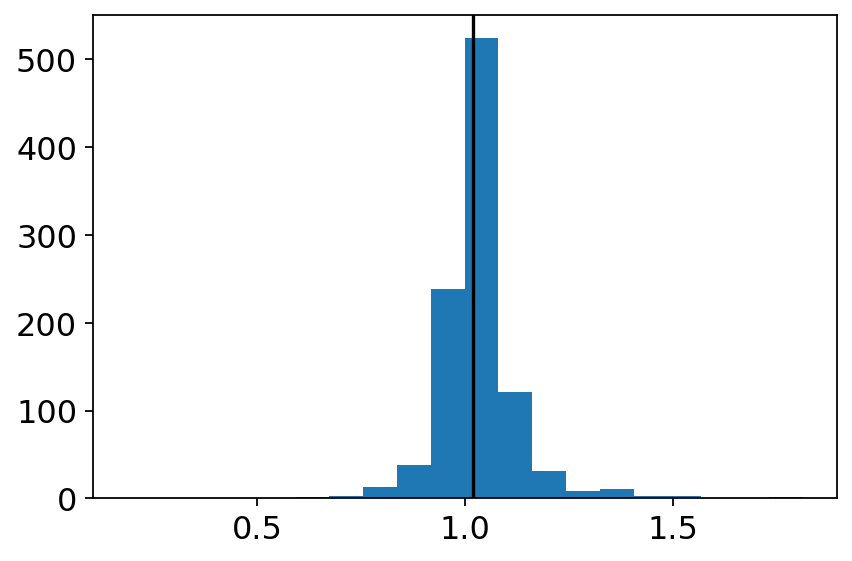

In [18]:
print(np.nanmean(alphas_standard), np.nanmedian(alphas_standard), np.nanstd(alphas_standard))
plt.hist(alphas_standard, bins=20)
plt.axvline(alpha_true_wmap, color='black')
#plt.xlim(0.8, 1.2)

In [120]:
cat_tag = '_L750_n2e-4_z057'
cf_tag = '_theory_bw6'
Nrealizations = 1000
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)
cosmo_base = nbodykit.cosmology.WMAP9
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

1.031846078511207 1.0308933602000407 0.03327719838239745


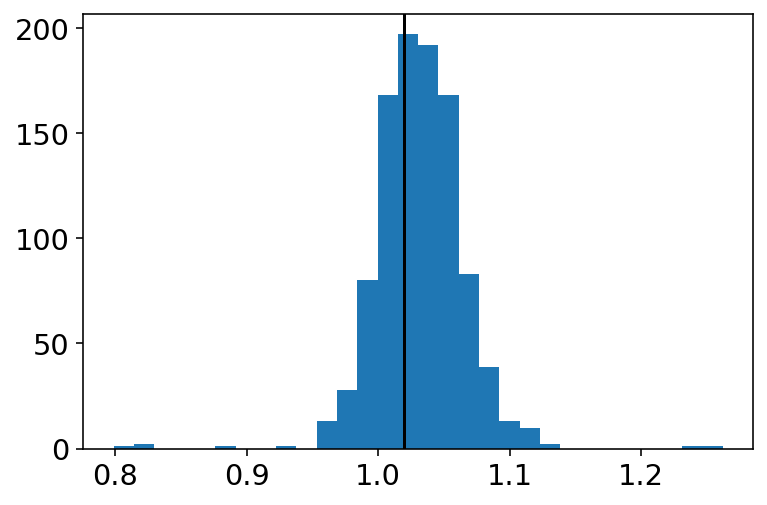

In [121]:
print(np.nanmean(alphas_standard), np.nanmedian(alphas_standard), np.nanstd(alphas_standard))
plt.hist(alphas_standard, bins=30)
plt.axvline(alpha_true_wmap, color='black')

In [117]:
cat_tag = '_L750_n2e-4_z057'
cf_tag = '_theory_bw3'
Nrealizations = 1000
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)
cosmo_base = nbodykit.cosmology.WMAP9
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

Optimal parameters for realization 606 not found! continuing


1.0313881101902092 1.03114388915549 0.03246819660140838


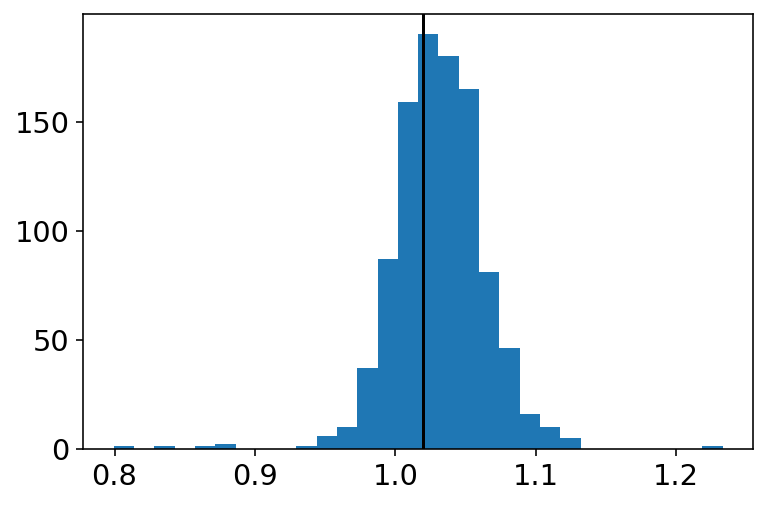

In [119]:
print(np.nanmean(alphas_standard), np.nanmedian(alphas_standard), np.nanstd(alphas_standard))
plt.hist(alphas_standard, bins=30)
plt.axvline(alpha_true_wmap, color='black')

## WMAP9

In [12]:
alpha_true_wmap = bao_utils.compute_alpha(0.57, cosmo_planck_lognormal, nbodykit.cosmology.WMAP9)

0.2588964265232328 0.048597561544344206 0.6774
0.24022 0.04628 0.6931999999999999
Truth: r_s: 158.26595003520382 D_A: 1386.683612636117 Mpc H: 92.95294554563436 km / (Mpc s)
Fiducial: r_s: 159.4432027919491 D_A: 1366.1903063144487 Mpc H: 93.58625071403947 km / (Mpc s)
alpha: 1.0197935804389602


412 1.5165085670079375
453 1.5317529361539968
Found 951 converged BAO cfs (49 not converged)
alpha_mean: 1.0300804135966544
alpha_median: 1.0239645385159202
alpha_std: 0.11321029466077952
1.0300804135966544 1.0239645385159202 0.11321029466077952


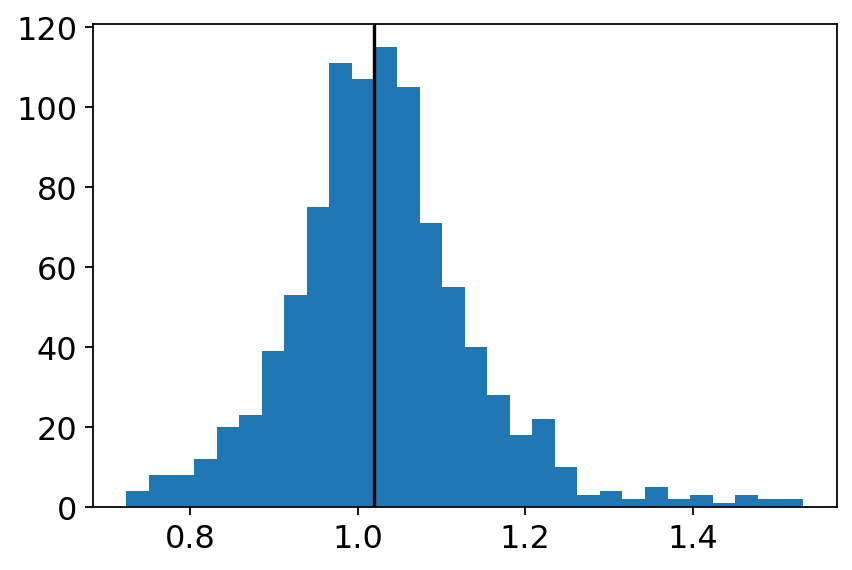

In [14]:
cat_tag = '_L750_n2e-5_z057'
cf_tag = '_baoiter_cosmowmap9'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))
plt.hist(alphas, bins=30)
plt.axvline(alpha_true_wmap, color='black')

555 1.5234431274189204
Found 937 converged BAO cfs (63 not converged)
alpha_mean: 1.0297831938422464
alpha_median: 1.0287284037208166
alpha_std: 0.06430915755246462
1.0297831938422464 1.0287284037208166 0.06430915755246462


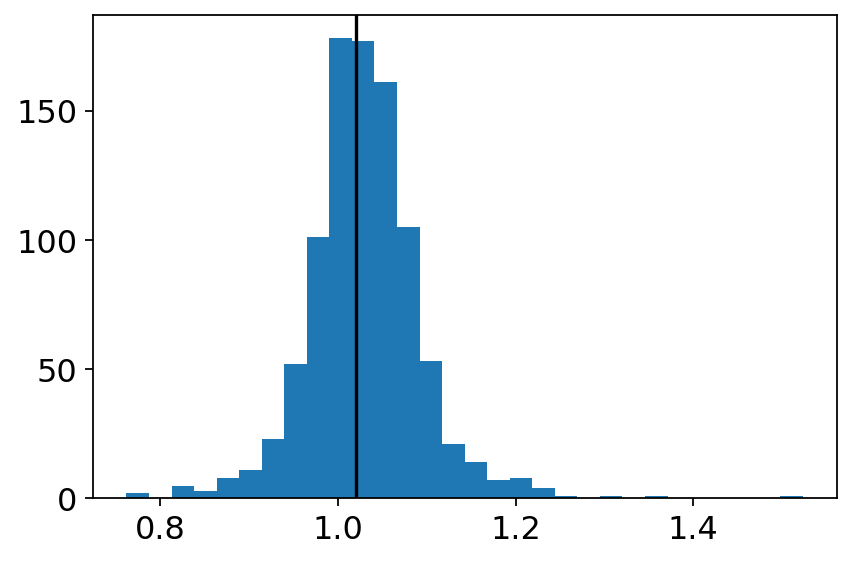

In [15]:
cat_tag = '_L750_n5e-5_z057'
cf_tag = '_baoiter_cosmowmap9'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))
plt.hist(alphas, bins=30)
plt.axvline(alpha_true_wmap, color='black')

Found 965 converged BAO cfs (35 not converged)
alpha_mean: 1.0286062422829827
alpha_median: 1.027358785600652
alpha_std: 0.03962778066795888
1.0286062422829827 1.027358785600652 0.03962778066795888


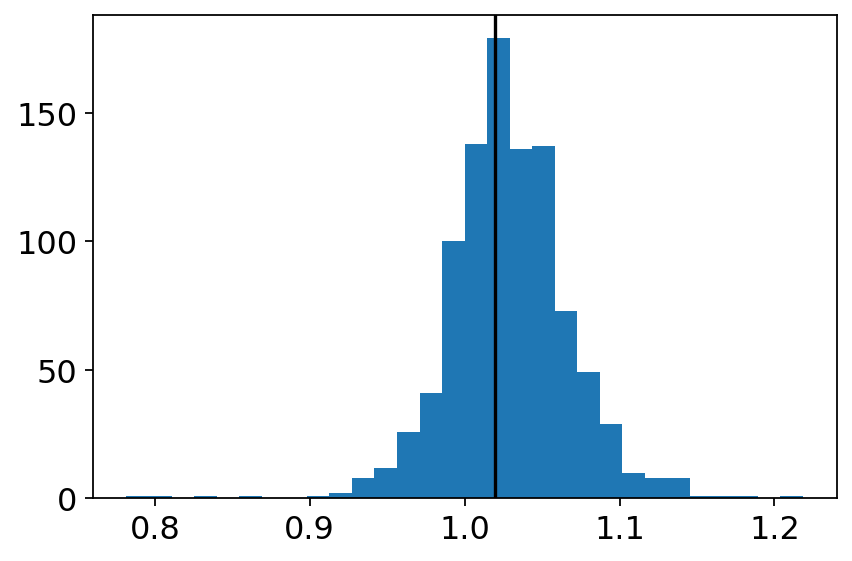

In [16]:
cat_tag = '_L750_n1e-4_z057'
cf_tag = '_baoiter_cosmowmap9'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))
plt.hist(alphas, bins=30)
plt.axvline(alpha_true_wmap, color='black')

In [92]:
Omega0_m = 0.307115
Omega0_b = 0.048206
Omega0_cdm = Omega0_m-Omega0_b
h0 = 0.6777
ns = 0.9611
sigma_8 = 0.8288
m_ncdm = [] #pass empty list for no massive neutrinos
print("Cosmo:", Omega0_cdm, Omega0_b, h0, ns)
cosmo_patchy = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                            n_s=ns, m_ncdm=m_ncdm)
cosmo_patchy.match(sigma8=sigma_8)

Cosmo: 0.25890900000000006 0.048206 0.6777 0.9611


In [75]:
Omega0_m = 0.31
h0 = 0.676
#Omega0_b = 0.04814
Omega0_b = 0.022/(h0**2)
Omega0_cdm = Omega0_m-Omega0_b

ns = 0.96
sigma_8 = 0.824
m_ncdm = [0.06]
print("Cosmo:", Omega0_cdm, Omega0_m, Omega0_b, h0, ns, sigma_8, m_ncdm)
cosmo_b17_correct = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                                 n_s=ns, sigma8=sigma_8, m_ncdm=m_ncdm)
print("befre:", cosmo_b17_correct.Omega0_cdm, cosmo_b17_correct.Omega0_m, cosmo_b17_correct.Omega0_b, 
      cosmo_b17_correct.h, cosmo_b17_correct.n_s, cosmo_b17_correct.sigma8, cosmo_b17_correct.m_ncdm)

print("after:", cosmo_b17_correct.Omega0_cdm, cosmo_b17_correct.Omega0_m, cosmo_b17_correct.Omega0_b, 
      cosmo_b17_correct.h, cosmo_b17_correct.n_s, cosmo_b17_correct.sigma8, cosmo_b17_correct.m_ncdm)
#bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_b17_correct)

Cosmo: 0.26185742796120587 0.31 0.04814257203879415 0.676 0.96 0.824 [0.06]
after: 0.26185742796120587 0.3114095617777392 0.04814257203879415 0.676 0.96 0.8240471953116799 [0.06]


In [76]:
bao_utils.compute_alpha(0.57, cosmo_patchy, cosmo_b17_correct)

0.25890900000000006 0.048206 0.6777
0.26185742796120587 0.04814257203879415 0.676
Truth: r_s: 158.38224113487712 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 158.27017152996024 D_A: 1387.4775717166528 Mpc H: 93.03626971186141 km / (Mpc s)
alpha: 0.9989604597170435


<Quantity 0.99896046>

In [8]:
Omega0_m = 0.31
h0 = 0.676
#Omega0_b = 0.04814
Omega0_b = 0.022/(h0**2)
Omega0_cdm =round(Omega0_m-Omega0_b, 6)
sigma_8 = 0.824
ns = 0.96
#m_ncdm = [0.06]
m_ncdm = []
print("Cosmo:", Omega0_cdm, Omega0_m, Omega0_b, h0, ns, sigma_8, m_ncdm)
cosmo_b17_correct = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                                 n_s=ns, m_ncdm=m_ncdm)
                  
print("before:", cosmo_b17_correct.Omega0_cdm, cosmo_b17_correct.Omega0_m, cosmo_b17_correct.Omega0_b, 
      cosmo_b17_correct.h, cosmo_b17_correct.n_s, cosmo_b17_correct.m_ncdm)
cosmo_b17_correct.match(sigma8=sigma_8)
print("after:", cosmo_b17_correct.Omega0_cdm, cosmo_b17_correct.Omega0_m, cosmo_b17_correct.Omega0_b, 
      cosmo_b17_correct.h, cosmo_b17_correct.n_s, cosmo_b17_correct.m_ncdm)
#bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_b17_correct)

Cosmo: 0.261857 0.31 0.04814257203879415 0.676 0.96 0.824 []
before: 0.261857 0.30999957203879414 0.04814257203879415 0.676 0.96 []
after: 0.261857 0.30999957203879414 0.04814257203879415 0.676 0.96 []


In [83]:

print("after:", cosmo_b17_correct.Omega0_cdm, cosmo_b17_correct.Omega0_m, cosmo_b17_correct.Omega0_b, 
      cosmo_b17_correct.h, cosmo_b17_correct.n_s, cosmo_b17_correct.m_ncdm)

after: 0.26377065934278865 0.313322793159322 0.04814257203879415 0.676 0.96 [0.06]


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): Omega0_m
  self.engine = ClassEngine(pars)


In [84]:
bao_utils.compute_alpha(0.57, cosmo_patchy, cosmo_b17_correct)

0.25890900000000006 0.048206 0.6777
0.26377065934278865 0.04814257203879415 0.676
Truth: r_s: 158.38224113487712 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 157.9856405686456 D_A: 1386.4638003062457 Mpc H: 93.17102006547027 km / (Mpc s)
alpha: 0.9981320150662344


<Quantity 0.99813202>

In [37]:
for k, v in cosmo_patchy:
    print(k,v)

output vTk dTk mPk
extra metric transfer functions y
h 0.6777
N_ur 2.0328
gauge synchronous
n_s 0.9611
sigma8 0.8288
T_cmb 2.7255
Omega_cdm 0.25890900000000006
Omega_b 0.048206
N_ncdm 1
m_ncdm [0.06]
P_k_max_h/Mpc 10.0
z_max_pk 100.0


In [71]:
cosmo = cosmo_b17_correct
print(cosmo.Omega0_m)
Omh2 = cosmo.Omega0_m * cosmo.h**2
Ombh2 = cosmo.Omega0_b * cosmo.h**2
r_s = 44.5 * np.log(9.83 / Omh2) / np.sqrt(1.0 + 10.0 * Ombh2**0.75) * cosmo.h
print(r_s/cosmo.h)

0.3114095617777392
150.3536419935225


In [94]:
bao_utils.compute_alpha(0.57, cosmo_patchy, cosmo_b17_correct)

0.307115 0.25890900000000006 0.048206 0.6777
0.3119132313815828 0.26377065934278865 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.38932913308707 D_A: 1386.4638003062457 Mpc H: 93.17102006547027 km / (Mpc s)
rs_truth_col 150.53793048861854 rs_fid_col 150.2962697460865
alpha: 0.9987370586438901
alpha_col: 0.9990313457524477


<Quantity 0.99873706>

In [95]:
bao_utils.compute_alpha(0.57, cosmo_patchy, cosmo_b17_correct)

0.307115 0.25890900000000006 0.048206 0.6777
0.3119132313815828 0.26377065934278865 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.38932913308707 D_A: 1386.4638003062457 Mpc H: 93.17102006547027 km / (Mpc s)
rs_truth_col 102.01955549213677 rs_fid_col 101.60027834835448
alpha: 0.9987370586438901
alpha_col: 0.9965252910264936


<Quantity 0.99873706>

In [6]:
cb17 = bao_utils.get_cosmo('b17')
cpatchy = bao_utils.get_cosmo('patchy')
bao_utils.compute_alpha(0.57, cpatchy, cb17)

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): Omega0_m
  self.engine = ClassEngine(pars)


0.307115 0.258909 0.048206 0.6777
0.3119132313815828 0.26377065934278865 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.38932913308707 D_A: 1386.4638003062457 Mpc H: 93.17102006547027 km / (Mpc s)
rs_truth_col 102.01955549213677 rs_fid_col 101.60027834835448
alpha: 0.9987370586438901
alpha_col: 0.9965252910264936


<Quantity 0.99873706>

In [9]:
def nbodykit_to_lognormal_galaxies(cosmo):
    print("oc0h2 =", cosmo.Omega0_cdm * cosmo.h**2, '  # \Omega_c h^2')
    print("mnu =", float(sum(cosmo.m_ncdm)), r'  # \Sigma m_{\nu} total neutrino mass')
    print("ns =", cosmo.n_s)
    print("lnAs =", np.log(cosmo.A_s/1e-10))
    print("ob0h2 =", cosmo.Omega0_b * cosmo.h**2, '  #\Omega_baryon h^2')
    print("h0 =", cosmo.h, '  # H0/100')
    print("w = -1")
    print("run = 0.0   # running index of pk")

In [16]:
bao_utils.nbodykit_to_lognormal_galaxies(cpatchy)

oc0h2 = 0.118911   # \Omega_c h^2
mnu = 0.0   # \Sigma m_{\nu} total neutrino mass
ns = 0.9611
lnAs = 3.097837
ob0h2 = 0.02214   #\Omega_baryon h^2
h0 = 0.6777   # H0/100
w = -1
run = 0.0   # running index of pk


# PATCHY mocks

(1, 20)
rmse: True
plotting
0.0010186 100000.0


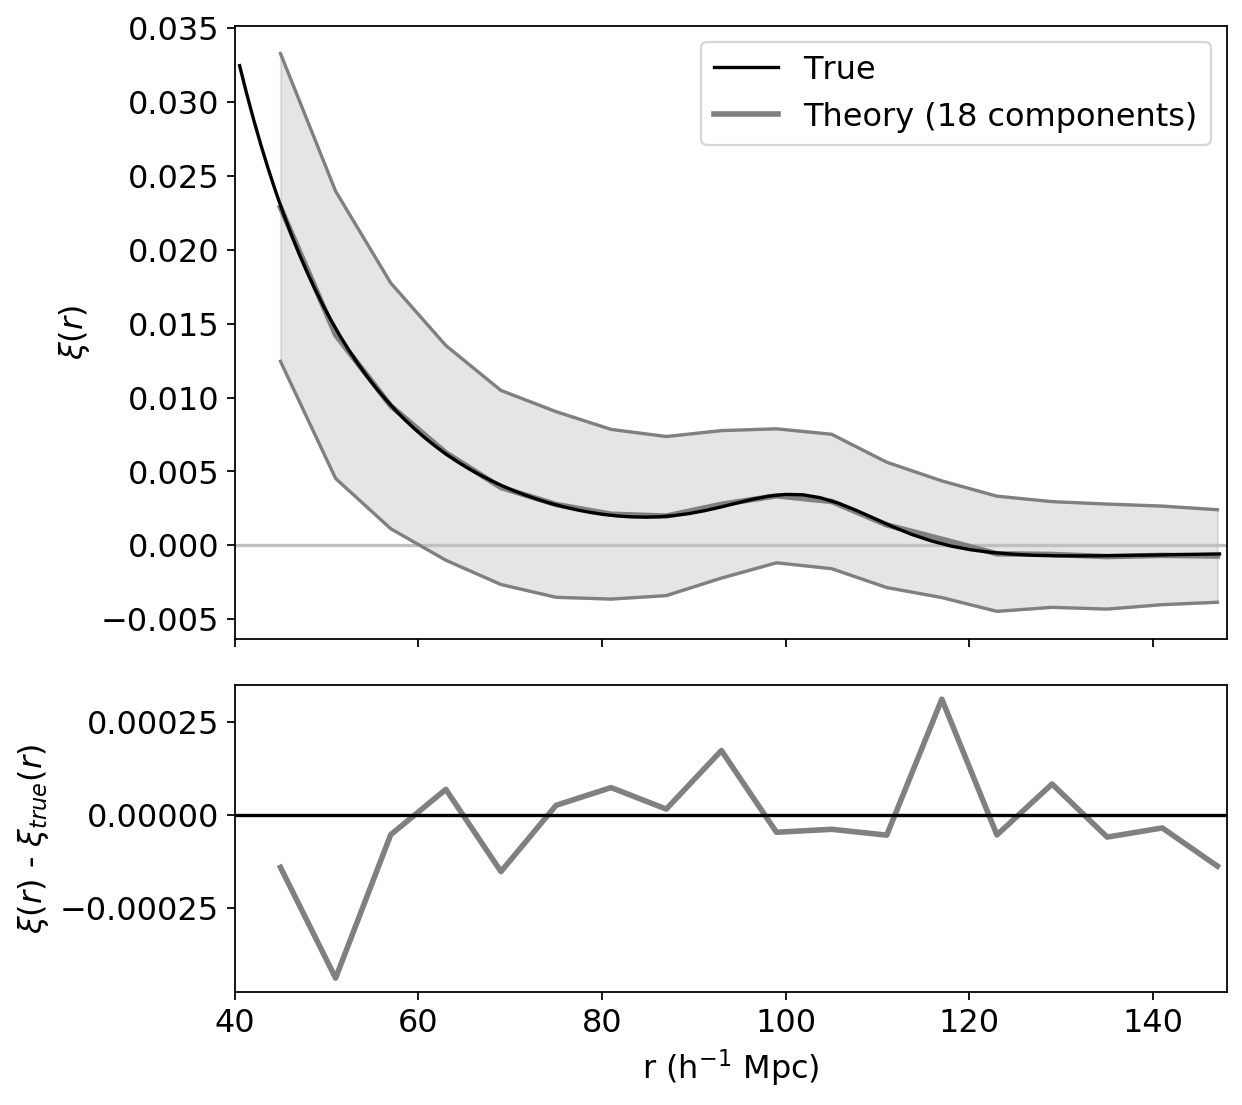

In [16]:
cat_tag = '_L750_n2e-5_z057_patchy'
cf_tags = ['_theory_bw6']
colors = [ctheory]
labels = ['Theory (18 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000, show_bases=False)

In [7]:
cb17 = bao_utils.get_cosmo('b17')
cpatchy = bao_utils.get_cosmo('patchy')
alpha_true = bao_utils.compute_alpha(0.57, cpatchy, cb17)

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): Omega0_m
  self.engine = ClassEngine(pars)


0.307115 0.258909 0.048206 0.6777
0.3119132313815828 0.26377065934278865 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.38932913308707 D_A: 1386.4638003062457 Mpc H: 93.17102006547027 km / (Mpc s)
rs_truth_col 150.53793048861854 rs_fid_col 150.2962697460865
alpha: 0.9987370586438901
alpha_col: 0.9990313457524477


In [18]:
cat_tag = '_L750_n2e-5_z057_patchy'
cf_tag = '_theory_bw6'
cosmo_base = bao_utils.get_cosmo('b17')
Nrealizations = 1000
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

/home/users/ksf293/miniconda3/lib/python3.7/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): Omega0_m
  self.engine = ClassEngine(pars)


Optimal parameters for realization 92 not found! continuing
Optimal parameters for realization 163 not found! continuing
Optimal parameters for realization 258 not found! continuing
Optimal parameters for realization 280 not found! continuing
Optimal parameters for realization 288 not found! continuing
Optimal parameters for realization 519 not found! continuing
Optimal parameters for realization 553 not found! continuing
Optimal parameters for realization 585 not found! continuing
Optimal parameters for realization 711 not found! continuing
Optimal parameters for realization 776 not found! continuing
Optimal parameters for realization 779 not found! continuing
Optimal parameters for realization 827 not found! continuing
Optimal parameters for realization 894 not found! continuing
Optimal parameters for realization 933 not found! continuing


1.024207186836326 1.0025933298486631 0.24435684966764262


(0.5, 1.5)

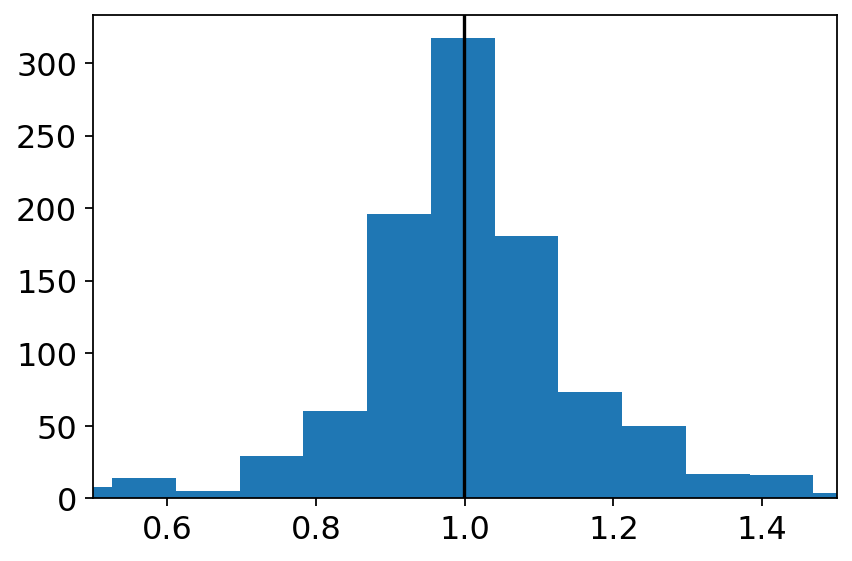

In [23]:
print(np.nanmean(alphas_standard), np.nanmedian(alphas_standard), np.nanstd(alphas_standard))
plt.hist(alphas_standard, bins=55)
plt.axvline(alpha_true, color='black')
plt.xlim(0.5,1.5)

Now try with true cosmology, should recover alpha=1.0

In [24]:
cat_tag = '_L750_n2e-5_z057_patchy'
cf_tag = '_theory_bw6'
cosmo_base = bao_utils.get_cosmo('patchy')
Nrealizations = 1000
r_arr, xi_arr = load_data(cat_tag, cf_tag, Nrealizations=Nrealizations)
alphas_standard = bao_utils.bao_fit_standard(r_arr, xi_arr, cosmo_base, redshift=0.57, bias=2.0, realizations=range(Nrealizations))

Optimal parameters for realization 34 not found! continuing
Optimal parameters for realization 163 not found! continuing
Optimal parameters for realization 288 not found! continuing
Optimal parameters for realization 519 not found! continuing
Optimal parameters for realization 525 not found! continuing
Optimal parameters for realization 553 not found! continuing
Optimal parameters for realization 585 not found! continuing
Optimal parameters for realization 779 not found! continuing
Optimal parameters for realization 827 not found! continuing
Optimal parameters for realization 893 not found! continuing
Optimal parameters for realization 894 not found! continuing
Optimal parameters for realization 937 not found! continuing
Optimal parameters for realization 983 not found! continuing


1.0204633702317014 1.0062308900094352 0.17557780772951037


(0.5, 1.5)

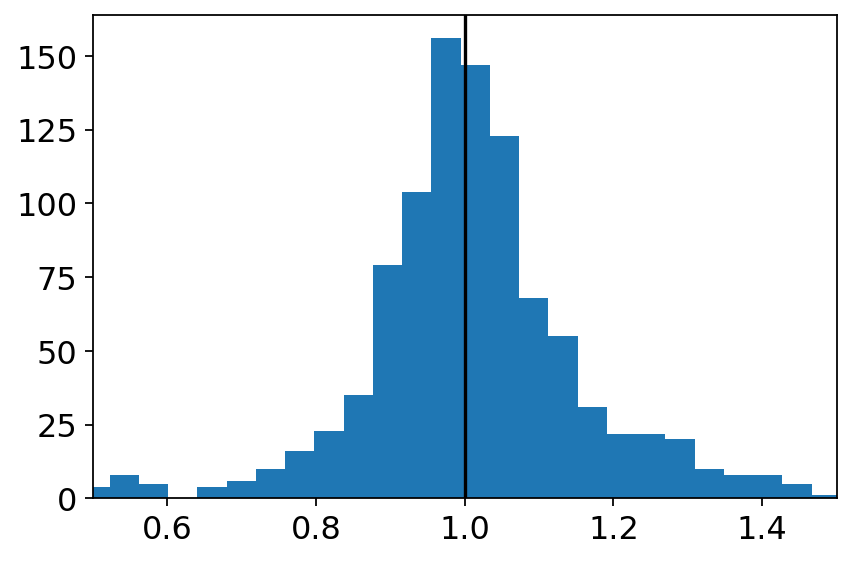

In [26]:
print(np.nanmean(alphas_standard), np.nanmedian(alphas_standard), np.nanstd(alphas_standard))
plt.hist(alphas_standard, bins=55)
plt.axvline(1.0, color='black')
plt.xlim(0.5,1.5)

Number converged: 946/1000
(2, 1000)
rmse: True
plotting
0.0010186 100000.0


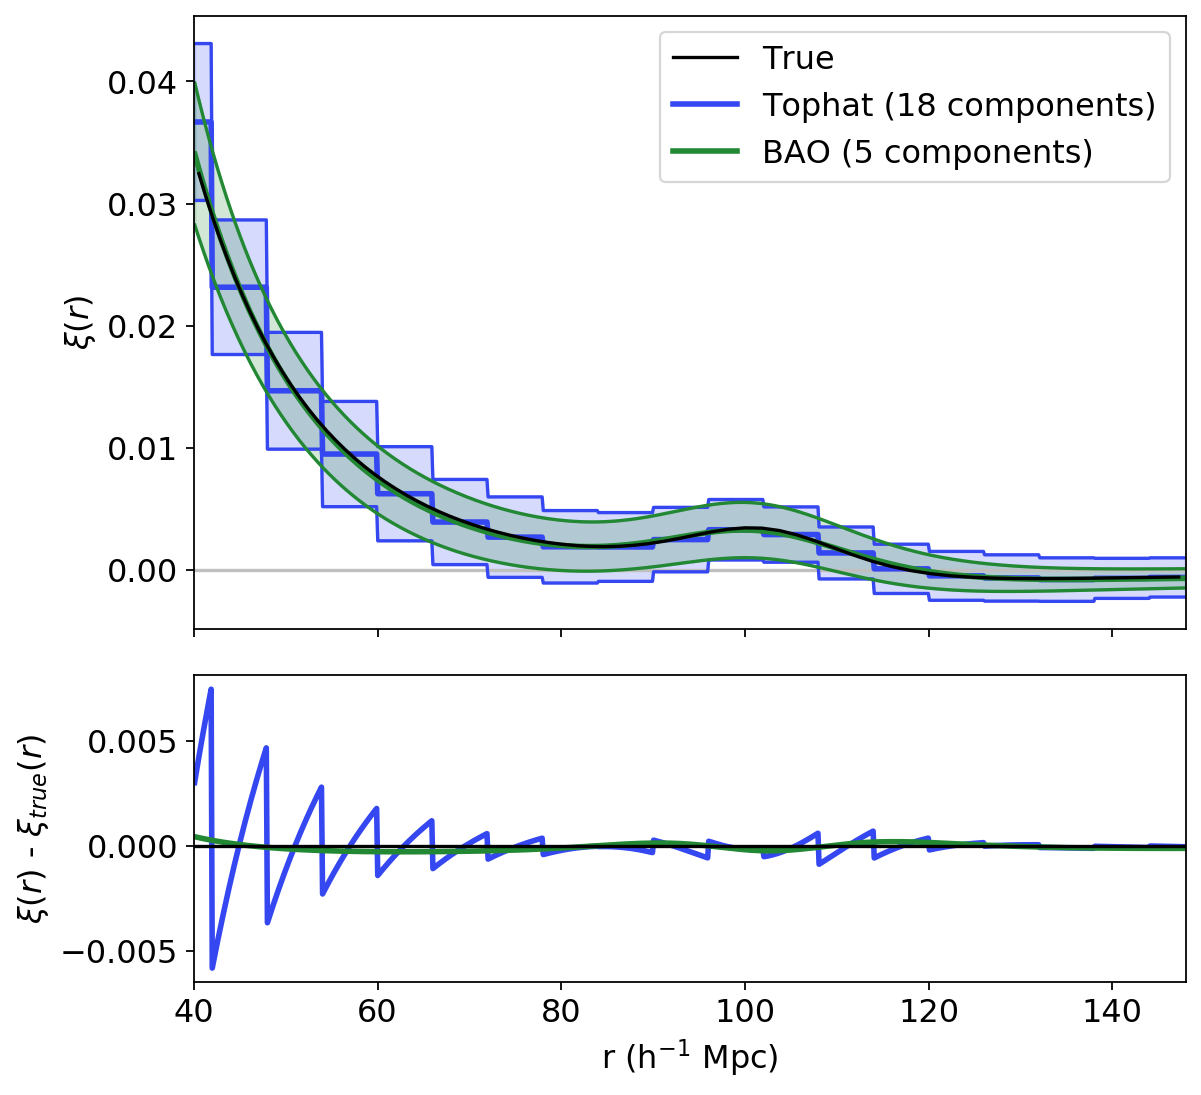

In [13]:
cat_tag = '_L750_n5e-5_z057_patchy'
cf_tags = ['_tophat_bw6', '_baoiter_cosmob17']
colors = [ctopmid, cbao]
labels = ['Tophat (18 components)', 'BAO (5 components)']

ax = plot_continuous(cat_tag, cf_tags, colors=colors, labels=labels, peak_fit=False, Nrealizations=1000, show_bases=False)

522 1.589821103398735
Found 987 converged BAO cfs (13 not converged)
alpha_mean: 1.0008893393452738
alpha_median: 0.9958571770178866
alpha_std: 0.11363289299738404
1.0008893393452738 0.9958571770178866 0.11363289299738404


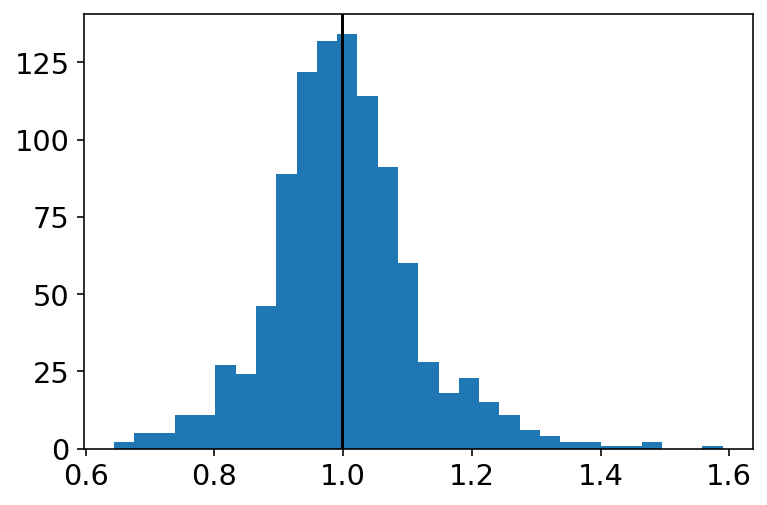

In [8]:
cat_tag = '_L750_n2e-5_z057_patchy'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))
plt.hist(alphas, bins=30)
plt.axvline(alpha_true, color='black')

842 1.5484877296092945
Found 974 converged BAO cfs (26 not converged)
alpha_mean: 0.9919455253455145
alpha_median: 0.9938918770023666
alpha_std: 0.0724675116086887
0.9919455253455145 0.9938918770023666 0.0724675116086887


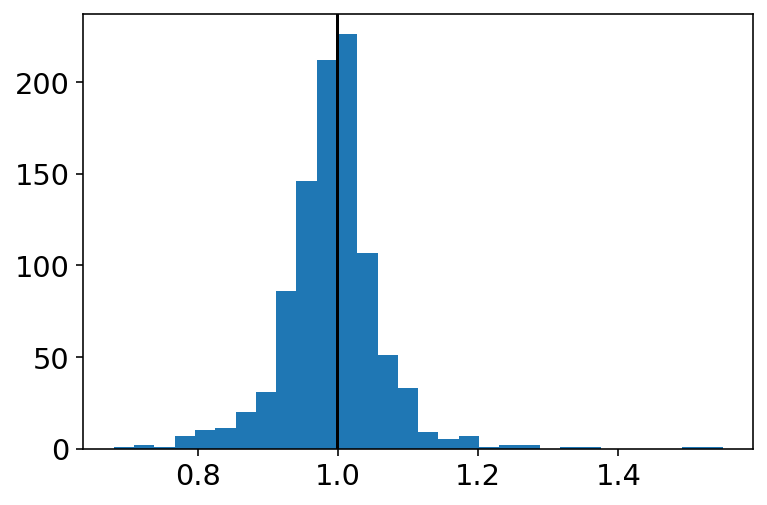

In [9]:
cat_tag = '_L750_n5e-5_z057_patchy'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))
plt.hist(alphas, bins=30)
plt.axvline(alpha_true, color='black')

Found 977 converged BAO cfs (23 not converged)
alpha_mean: 0.9936273110504694
alpha_median: 0.9927742461739055
alpha_std: 0.04199372742772743
0.9936273110504694 0.9927742461739055 0.04199372742772743


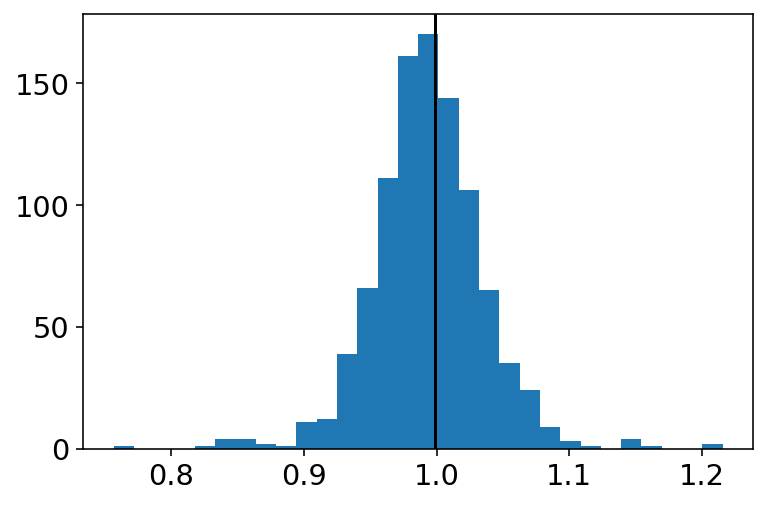

In [10]:
cat_tag = '_L750_n1e-4_z057_patchy'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))
plt.hist(alphas, bins=30)
plt.axvline(alpha_true, color='black')

Found 992 converged BAO cfs (8 not converged)
alpha_mean: 0.9923981601474664
alpha_median: 0.9927645369676352
alpha_std: 0.03287721562442208
0.9923981601474664 0.9927645369676352 0.03287721562442208


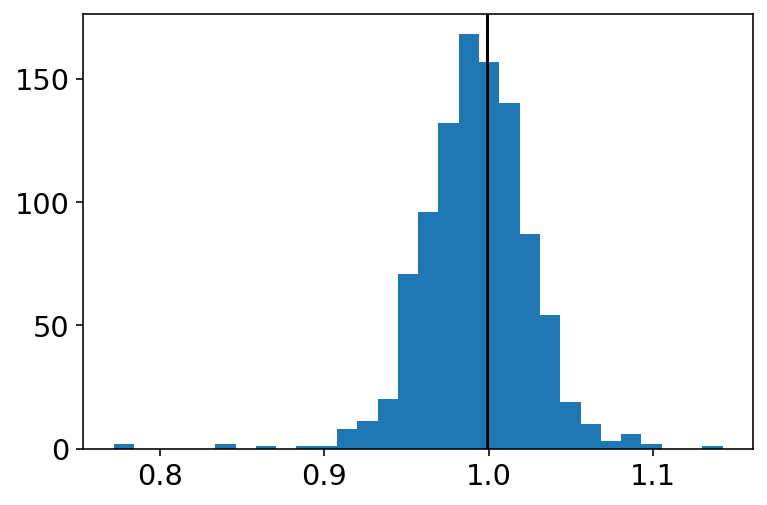

In [12]:
cat_tag = '_L750_n2e-4_z057_patchy'
cf_tag = '_baoiter_cosmob17'
alphas = bao_utils.get_alphas(cat_tag, cf_tag, realizations=range(1000))
print(np.nanmean(alphas), np.nanmedian(alphas), np.nanstd(alphas))
plt.hist(alphas, bins=30)
plt.axvline(alpha_true, color='black')

## Figure out omega_nu

In [56]:

h0 = 0.676
m_ncdm = [0.06]
#m_ncdm = []
rho_crit = 93.14 * h0**2 #in eV
Omega0_nu = np.sum(m_ncdm) / rho_crit
print(Omega0_nu)

Omega0_m = 0.31
#Omega0_b = 0.04814
Omega0_b = 0.022/(h0**2)
Omega0_cdm = round(Omega0_m-Omega0_b-Omega0_nu, 6)
sigma_8 = 0.824
ns = 0.96

cosmo_b17_check = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_m=Omega0_m, 
                                                 n_s=ns, m_ncdm=m_ncdm)

0.0014096835274013944


/home/users/ksf293/miniconda3/lib/python3.7/site-packages/nbodykit/cosmology/cosmology.py:427: UserWarning: Class did not read input parameter(s): Omega0_m
  self.engine = ClassEngine(pars)


In [58]:
cosmo_b17_check.Omega0_m

0.313322793159322

In [10]:

h0 = 0.676
m_ncdm = [0.06]
#m_ncdm = []
rho_crit = 93.14 * h0**2 #in eV
Omega0_nu = np.sum(m_ncdm) / rho_crit
print(Omega0_nu)

Omega0_m = 0.31
#Omega0_b = 0.04814
Omega0_b = 0.022/(h0**2)
Omega0_cdm = round(Omega0_m-Omega0_b-Omega0_nu, 6)
sigma_8 = 0.824
ns = 0.96


print("Cosmo:", Omega0_cdm, Omega0_m, Omega0_b, Omega0_nu, h0, ns, sigma_8, m_ncdm)
cosmo_b17_correct = nbodykit.cosmology.Cosmology(h=h0, Omega0_b=Omega0_b, Omega0_cdm=Omega0_cdm, 
                                                 n_s=ns, m_ncdm=m_ncdm)
                  
print("before:", cosmo_b17_correct.Omega0_cdm, cosmo_b17_correct.Omega0_m, cosmo_b17_correct.Omega0_b, 
      cosmo_b17_correct.h, cosmo_b17_correct.n_s, cosmo_b17_correct.m_ncdm)
cosmo_b17_correct.match(sigma8=sigma_8)
print("after:", cosmo_b17_correct.Omega0_cdm, cosmo_b17_correct.Omega0_m, cosmo_b17_correct.Omega0_b, 
      cosmo_b17_correct.h, cosmo_b17_correct.n_s, cosmo_b17_correct.m_ncdm)
#bao_utils.compute_alpha(0.57, cosmo_planck, cosmo_b17_correct)

0.0014096835274013944
Cosmo: 0.260448 0.31 0.04814257203879415 0.0014096835274013944 0.676 0.96 0.824 [0.06]
before: 0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06]
after: 0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06]


In [13]:
bao_utils.compute_alpha(0.57, cosmo_patchy, cosmo_b17_correct)

0.307115 0.25890900000000006 0.048206 0.6777
0.30859057203879414 0.260448 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1385.531684570546 Mpc H: 93.06560956380719 km / (Mpc s)
Fiducial: r_s: 151.8126244586909 D_A: 1388.2262919973946 Mpc H: 92.93687764109468 km / (Mpc s)
rs_truth_col 150.53793048861854 rs_fid_col 150.67647188394068
alpha: 0.9991346385546723
alpha_col: 0.9991635506195187


<Quantity 0.99913464>

In [14]:
cosmo_patchy = bao_utils.get_cosmo('patchy')

In [15]:
bao_utils.compute_alpha(0.57, cosmo_patchy, cosmo_b17_correct)

0.307115 0.258909 0.048206 0.6777
0.30859057203879414 0.260448 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.8126244586909 D_A: 1388.2262919973946 Mpc H: 92.93687764109468 km / (Mpc s)
rs_truth_col 150.53793048861854 rs_fid_col 150.67647188394068
alpha: 0.9998427705622829
alpha_col: 0.9998717031184202


<Quantity 0.99984277>

In [50]:
cosmo_b17 = bao_utils.get_cosmo('b17')
cosmo_patchy = bao_utils.get_cosmo('patchy')

z = 0.57
alpha_true = bao_utils.compute_alpha(z, cosmo_patchy, cosmo_b17) #1st is truth, 2nd is fiducial

0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06] 0.824 2.0328
0.258909 0.307115 0.048206 0.6777 0.9611 [] 0.8288000000000002 3.046
0.307115 0.258909 0.048206 0.6777
0.30859057203879414 0.260448 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.8126244586909 D_A: 1388.2262919973946 Mpc H: 92.93687764109468 km / (Mpc s)
rs_truth_col 150.53793048861854 rs_fid_col 150.67647188394068
alpha: 0.9998427705622829
alpha_col: 0.9998717031184202


In [60]:
cosmo_b17 = bao_utils.get_cosmo('b17')
cosmo_patchy = bao_utils.get_cosmo('patchy')

z = 0.57
alpha_true = bao_utils.compute_alpha(z, cosmo_patchy, cosmo_b17) #1st is truth, 2nd is fiducial

0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06] 0.824 2.0328
0.258909 0.307115 0.048206 0.6777 0.9611 [] 0.8288000000000002 3.046
0.307115 0.258909 0.048206 0.6777
0.31000013381653335 0.260448 0.04814257203879415 0.676
Truth: r_s: 151.67742739223243 D_A: 1386.2717028870238 Mpc H: 92.96723916119726 km / (Mpc s)
Fiducial: r_s: 151.63251902228856 D_A: 1388.2262919973946 Mpc H: 92.93687764109468 km / (Mpc s)
rs_truth_col 150.53793048861854 rs_fid_col 150.51468231796673
alpha: 0.998656590432877
alpha_col: 0.998798086203619


In [59]:
cosmo_b17 = bao_utils.get_cosmo('b17')
cosmo_planck = bao_utils.get_cosmo('planck')

z = 0.57
alpha_true = bao_utils.compute_alpha(z, cosmo_planck, cosmo_b17) #1st is truth, 2nd is fiducial

0.260448 0.31000013381653335 0.04814257203879415 0.676 0.96 [0.06] 0.824 2.0328
0.2589 0.30890374144332966 0.0486 0.6774 0.9667 [0.06] 0.8158116144901115 2.0328
0.30890374144332966 0.2589 0.0486 0.6774
0.31000013381653335 0.260448 0.04814257203879415 0.676
Truth: r_s: 151.33872766346497 D_A: 1385.9398472195844 Mpc H: 93.05175647764855 km / (Mpc s)
Fiducial: r_s: 151.63251902228856 D_A: 1388.2262919973946 Mpc H: 92.93687764109468 km / (Mpc s)
rs_truth_col 150.21400072740965 rs_fid_col 150.51468231796673
alpha: 1.0004287935768108
alpha_col: 1.000489107184109


In [48]:
alpha_true = bao_utils.compute_alpha(z, cosmo_planck_lognormal, cosmo_b17) #1st is truth, 2nd is fiducial

0.307493988067577 0.2588964265232328 0.048597561544344206 0.6774
0.30859057203879414 0.260448 0.04814257203879415 0.676
Truth: r_s: 151.520054436277 D_A: 1386.683612636117 Mpc H: 92.95294554563436 km / (Mpc s)
Fiducial: r_s: 151.8126244586909 D_A: 1388.2262919973946 Mpc H: 92.93687764109468 km / (Mpc s)
rs_truth_col 150.37712164739278 rs_fid_col 150.67647188394068
alpha: 1.0011308000945405
alpha_col: 1.0011905161328303


In [34]:
cosmo_patchy.N_ur

3.046

In [54]:
cosmo_patchy.Omega0_m

0.307115

In [55]:
cosmo_b17.Omega0_m

0.31000013381653335

In [49]:
print(cosmo_b17)

{'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'h': 0.676, 'N_ur': 2.0328, 'gauge': 'synchronous', 'n_s': 0.96, 'T_cmb': 2.7255, 'Omega_cdm': 0.260448, 'Omega_b': 0.04814257203879415, 'N_ncdm': 1, 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0, 'A_s': 2.1820573796701317e-09, 'm_ncdm': [0.06]}


In [52]:
print(cosmo_patchy)

{'output': 'vTk dTk mPk', 'extra metric transfer functions': 'y', 'h': 0.6777, 'N_ur': 3.046, 'gauge': 'synchronous', 'n_s': 0.9611, 'T_cmb': 2.7255, 'Omega_cdm': 0.258909, 'Omega_b': 0.048206, 'N_ncdm': 0, 'P_k_max_h/Mpc': 10.0, 'z_max_pk': 100.0, 'A_s': 2.146628225356469e-09}


In [62]:
bao_utils.nbodykit_to_lognormal_galaxies(cosmo_patchy)

oc0h2 = 0.118911   # \Omega_c h^2
mnu = 0.0   # \Sigma m_{\nu} total neutrino mass
ns = 0.9611
lnAs = 3.066483
ob0h2 = 0.02214   #\Omega_baryon h^2
h0 = 0.6777   # H0/100
w = -1
run = 0.0   # running index of pk
